In [1]:
import aug_standart_ztf
import fulu
import gp_aug as gp_aug_old
from sklearn.gaussian_process.kernels import RBF, Matern, \
RationalQuadratic, WhiteKernel, DotProduct, ConstantKernel as C
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from importlib import reload
reload(fulu)
import fulu
from fulu import bnn_aug
from fulu import nf_aug
from fulu import single_layer_aug
from fulu import mlp_reg_aug
from fulu import gp_aug
from fulu import *
import warnings
warnings.filterwarnings('ignore')


path = '/home/masha/AstroAugumetation/'
path_to = "/home/masha/AstroAugumetation/ZTF_BTS_02_02__02_04_2021.csv"
passband2lam  = {0: 1, 1: 2} # green, red 
N_OBS = 1000
cool_objects = ['ZTF20aahbamv', 'ZTF19abirmkt']
models_dict = {'BNN': bnn_aug.BayesianNetAugmentation(passband2lam),
               'NF': nf_aug.NormalizingFlowAugmentation(passband2lam),
               'NN (pytorch)': single_layer_aug.SingleLayerNetAugmentation(passband2lam),
               'NN (sklearn)': mlp_reg_aug.MLPRegressionAugmentation(passband2lam),
               'GP': gp_aug.GaussianProcessesAugmentation(passband2lam),
               'GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel()': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel(),  False),\
               'GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel()': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel())}

bts = pd.read_csv(path_to, sep =',')
bts = bts.drop('Unnamed: 0', 1)
df_all = pd.read_csv(path + 'ANTARES.csv')
print("Количество объектов: ", len(df_all['object_id'].unique()))
obj_names = df_all['object_id'].unique()
df_all.loc[df_all.obj_type == 'SN Ia', 'obj_type'] = 1
df_all.loc[df_all.obj_type != 1, 'obj_type'] = 0

def test(model_name):
    model = models_dict[model_name]
    for name in cool_objects:
        anobject = aug_standart_ztf.get_object(df_all, name)
        anobject_train, anobject_test = train_test_split(anobject, test_size = 0.5, random_state=11)

        model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
              anobject_train['flux_err'].values, anobject_train['passband'].values)

        
        # augmentation
        t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                      anobject['mjd'].max(), 
                                                                      n_obs=N_OBS)
        
        
        model.plot()
        model.plot(plot_approx = False)
        model.plot(passband=1)
        model.plot(passband=0)
        model.plot(true_peak=59000)
        model.plot(plot_peak=True)
        model.plot(title="Amazing graph")
        model.plot(true_peak=59000, plot_peak=True,
                             title="Amazing graph", save=model_name + "_" + name + "_21092021")
        plotic = LcPlotter(passband2lam)
        ax = plotic.errorbar_passband(t=anobject_train['mjd'].values, 
                                 flux=anobject_train['flux'].values, 
                                 flux_err=anobject_train['flux_err'].values, 
                                 passbands=anobject_train['passband'].values, 
                                 passband=1, title="train observation and approx curves")
        
        ax = plotic.plot_sum_passbands(t_approx=t_aug, 
                                  flux_approx=flux_aug,
                                  flux_err_approx=flux_err_aug, 
                                  passband_approx=passbands_aug)
        
        plotic.plot_one_graph_all(t=anobject_train['mjd'].values,
                             flux=anobject_train['flux'].values,
                             flux_err=anobject_train['flux_err'].values,
                             passbands=anobject_train['passband'].values, 
                                  plot_peak=True)
        plotic.plot_one_graph_all(t=anobject_train['mjd'].values,
                             flux=anobject_train['flux'].values,
                             flux_err=anobject_train['flux_err'].values,
                             passbands=anobject_train['passband'].values, 
                                  plot_peak=True,
                                  t_approx=t_aug, 
                                  flux_approx=flux_aug,
                                  flux_err_approx=flux_err_aug, 
                                  passband_approx=passbands_aug)
        ax = plotic.errorbar_passband(t=anobject_train['mjd'].values, 
                                 flux=anobject_train['flux'].values, 
                                 flux_err=anobject_train['flux_err'].values, 
                                 passbands=anobject_train['passband'].values, 
                                 passband=1, label='train')
        ax = plotic.errorbar_passband(t=anobject_test['mjd'].values,
                                flux=anobject_test['flux'].values,
                                flux_err=anobject_test['flux_err'].values,
                                passbands=anobject_test['passband'].values,
                                    passband = 1,
                                    ax=ax,
                                    label = 'test',
                                    marker = 'o')
        ax = plotic.errorbar_passband(t=anobject_train['mjd'].values, 
                                 flux=anobject_train['flux'].values, 
                                 flux_err=anobject_train['flux_err'].values, 
                                 passbands=anobject_train['passband'].values, 
                                 passband=0, ax=ax, label = 'train')
        
        ax = plotic.errorbar_passband(t=anobject_test['mjd'].values,
                                flux=anobject_test['flux'].values,
                                flux_err=anobject_test['flux_err'].values,
                                passbands=anobject_test['passband'].values,
                                      passband=0,
                                      ax=ax,
                                      marker = 'o',
                                      label='test')
        
        ax = plotic.plot_approx(t_approx=t_aug, 
                           flux_approx=flux_aug,
                           flux_err_approx=flux_err_aug,
                           passband_approx=passbands_aug,
                           passband=1)
        plotic.plot_approx(t_approx=t_aug, 
                           flux_approx=flux_aug,
                           flux_err_approx=flux_err_aug,
                           passband_approx=passbands_aug,
                           passband=0, ax=ax)
        
        plotic.plot_one_graph_passband(t=anobject_train['mjd'].values, 
                                       flux=anobject_train['flux'].values, 
                                       flux_err=anobject_train['flux_err'].values,
                                       passbands=anobject_train['passband'].values, 
                                       passband=0, title="Wow", t_approx=t_aug, 
                                  flux_approx=flux_aug,
                                  flux_err_approx=flux_err_aug, 
                                  passband_approx=passbands_aug)
        
        ax = plotic.plot_true_peak(true_peak = 59000, title="Title1")
        plotic.plot_true_peak(true_peak=59200, title="Title2", ax=ax)

Количество объектов:  1403


Your graph was saved
Your graph was saved


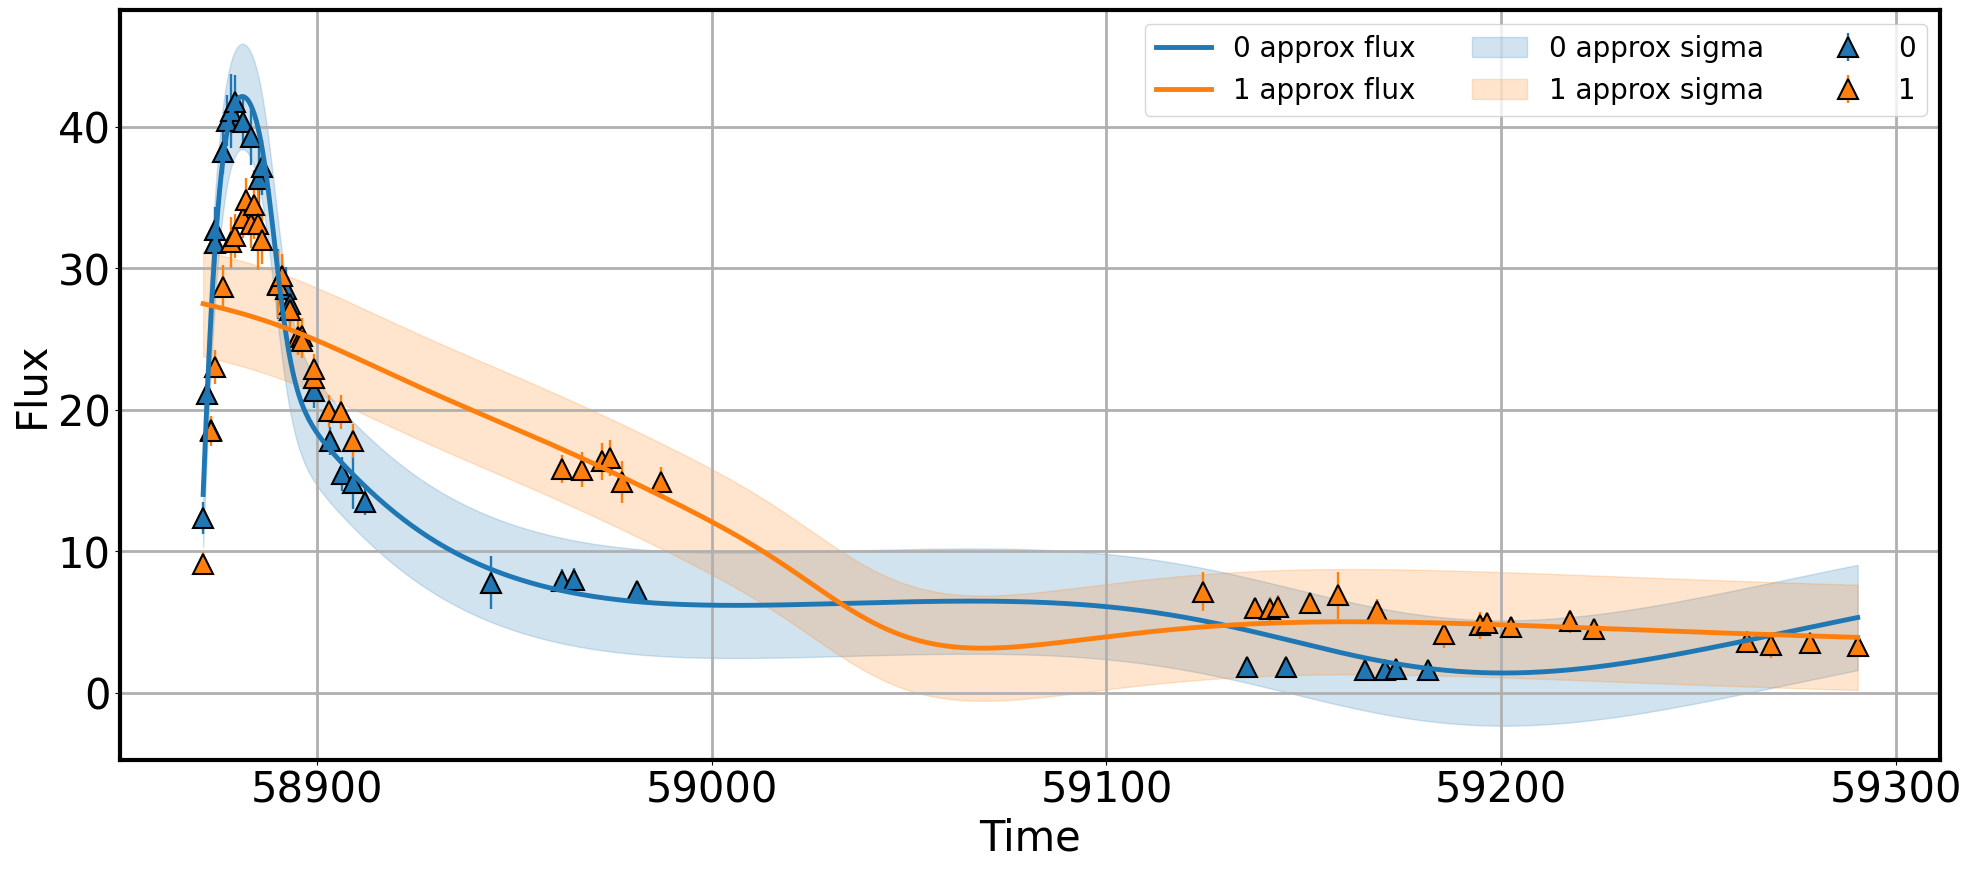

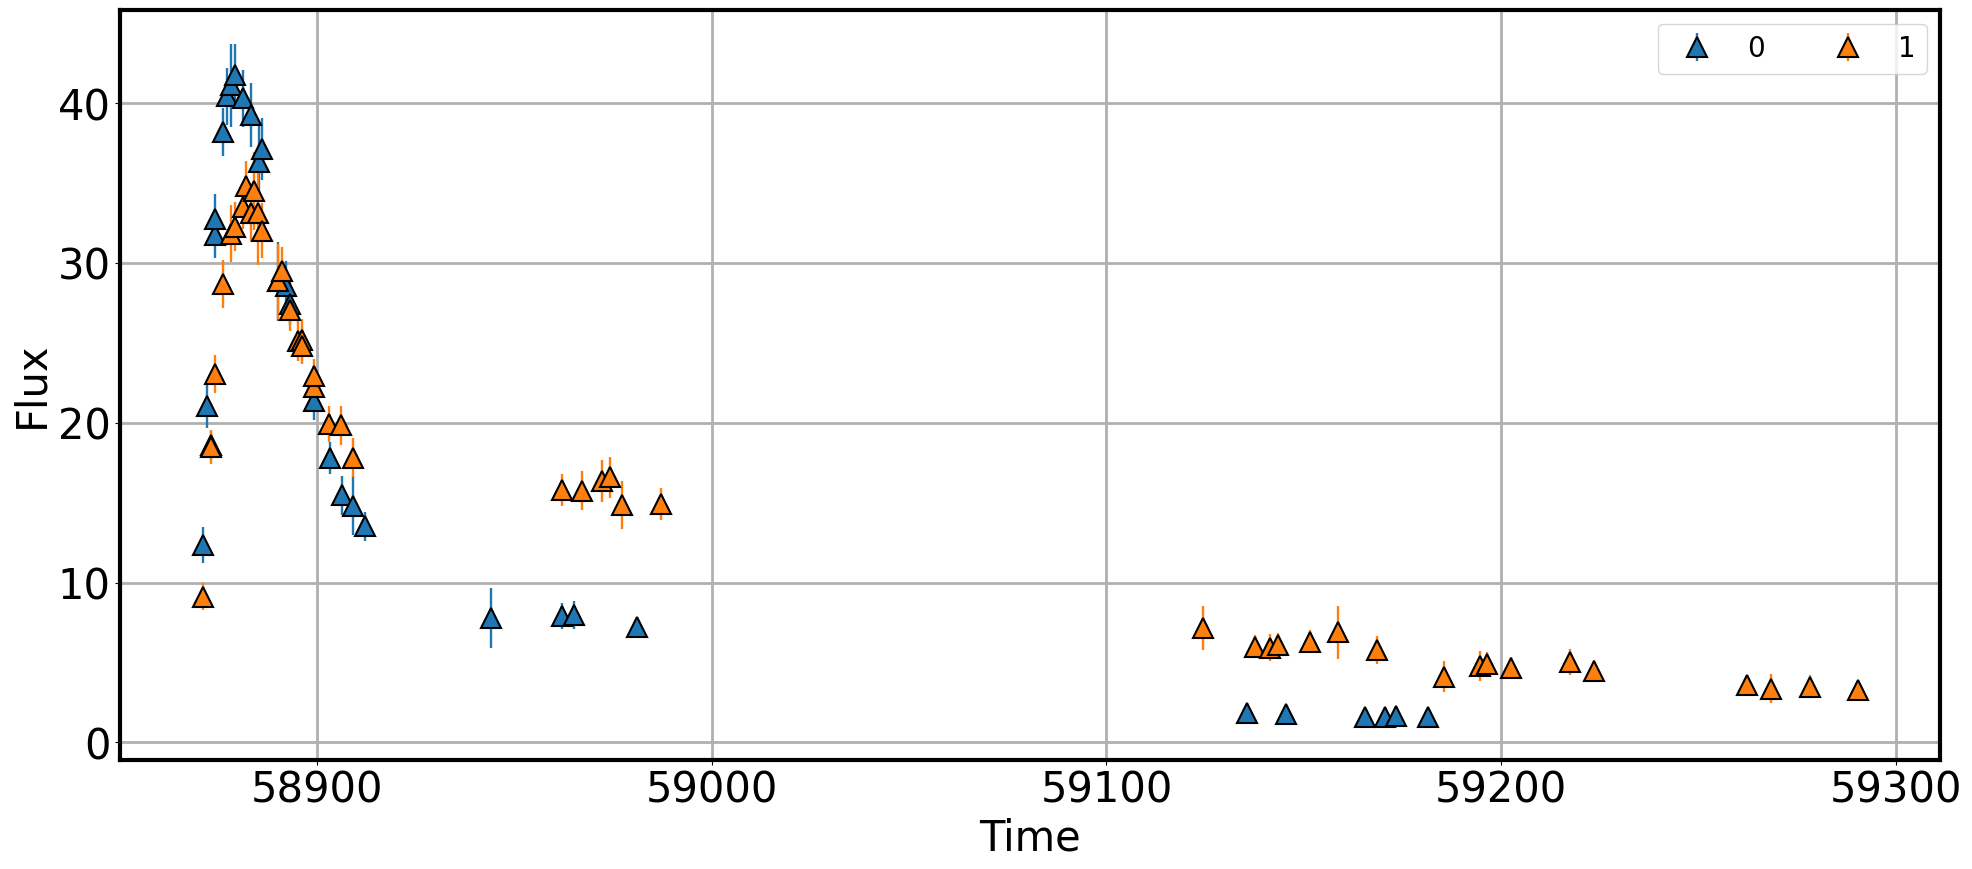

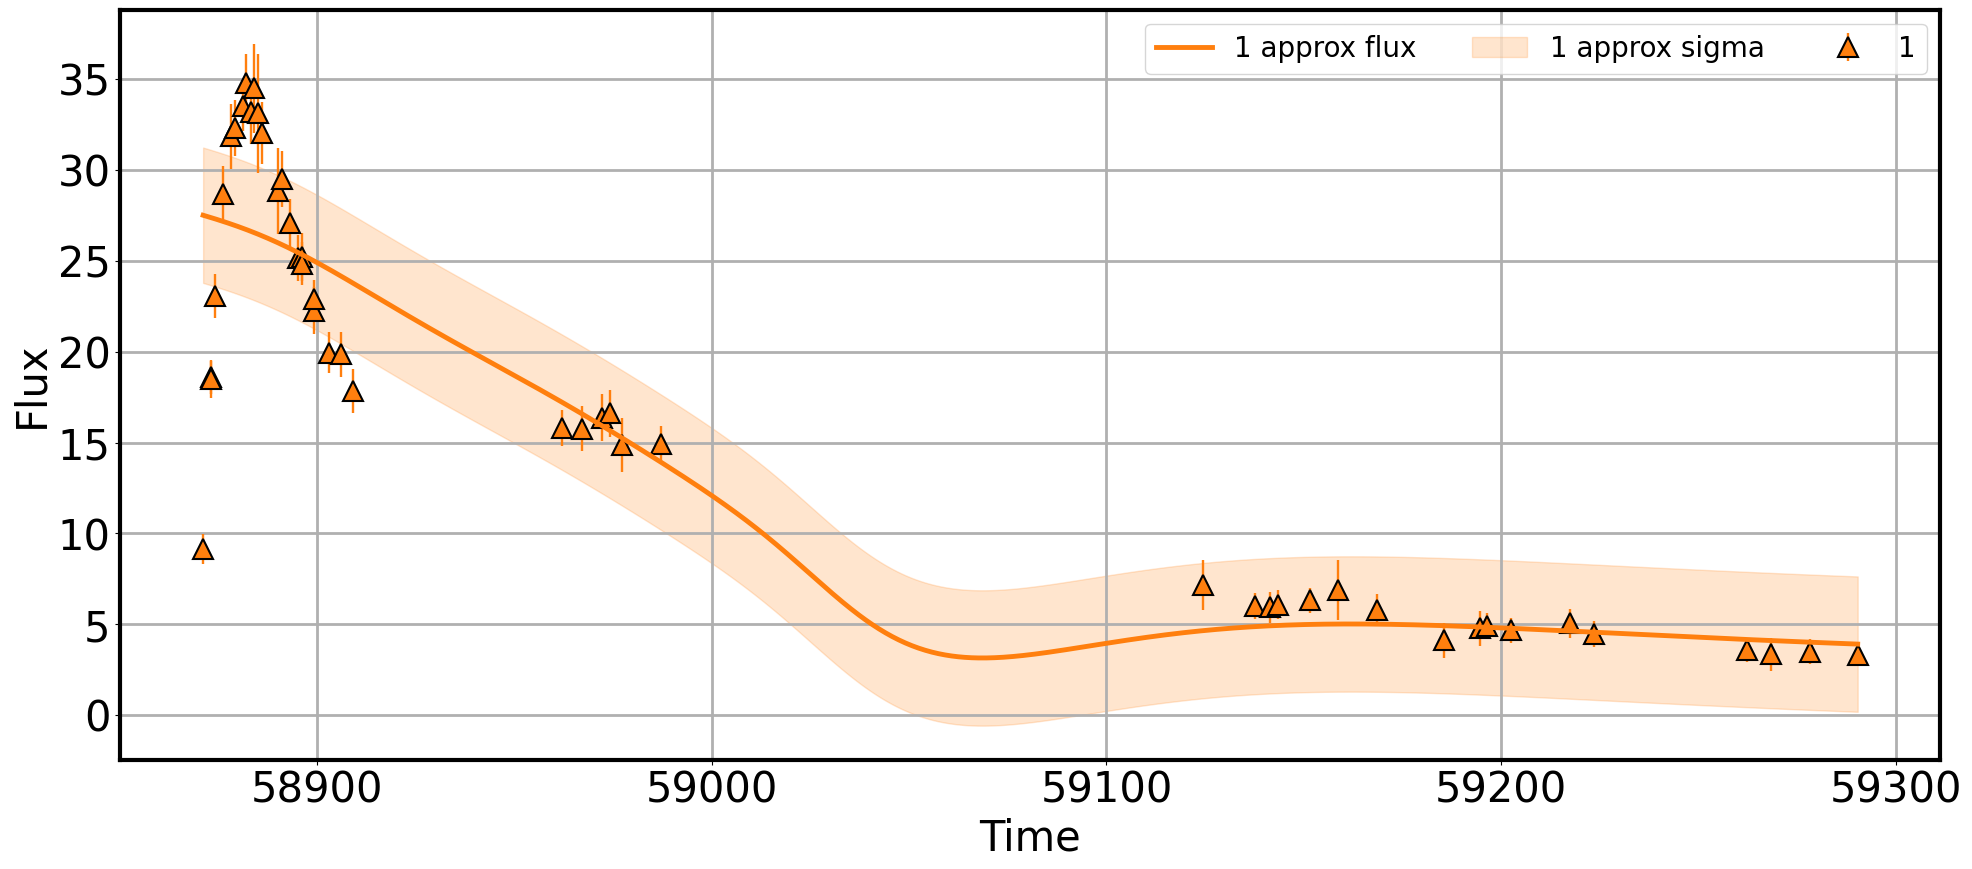

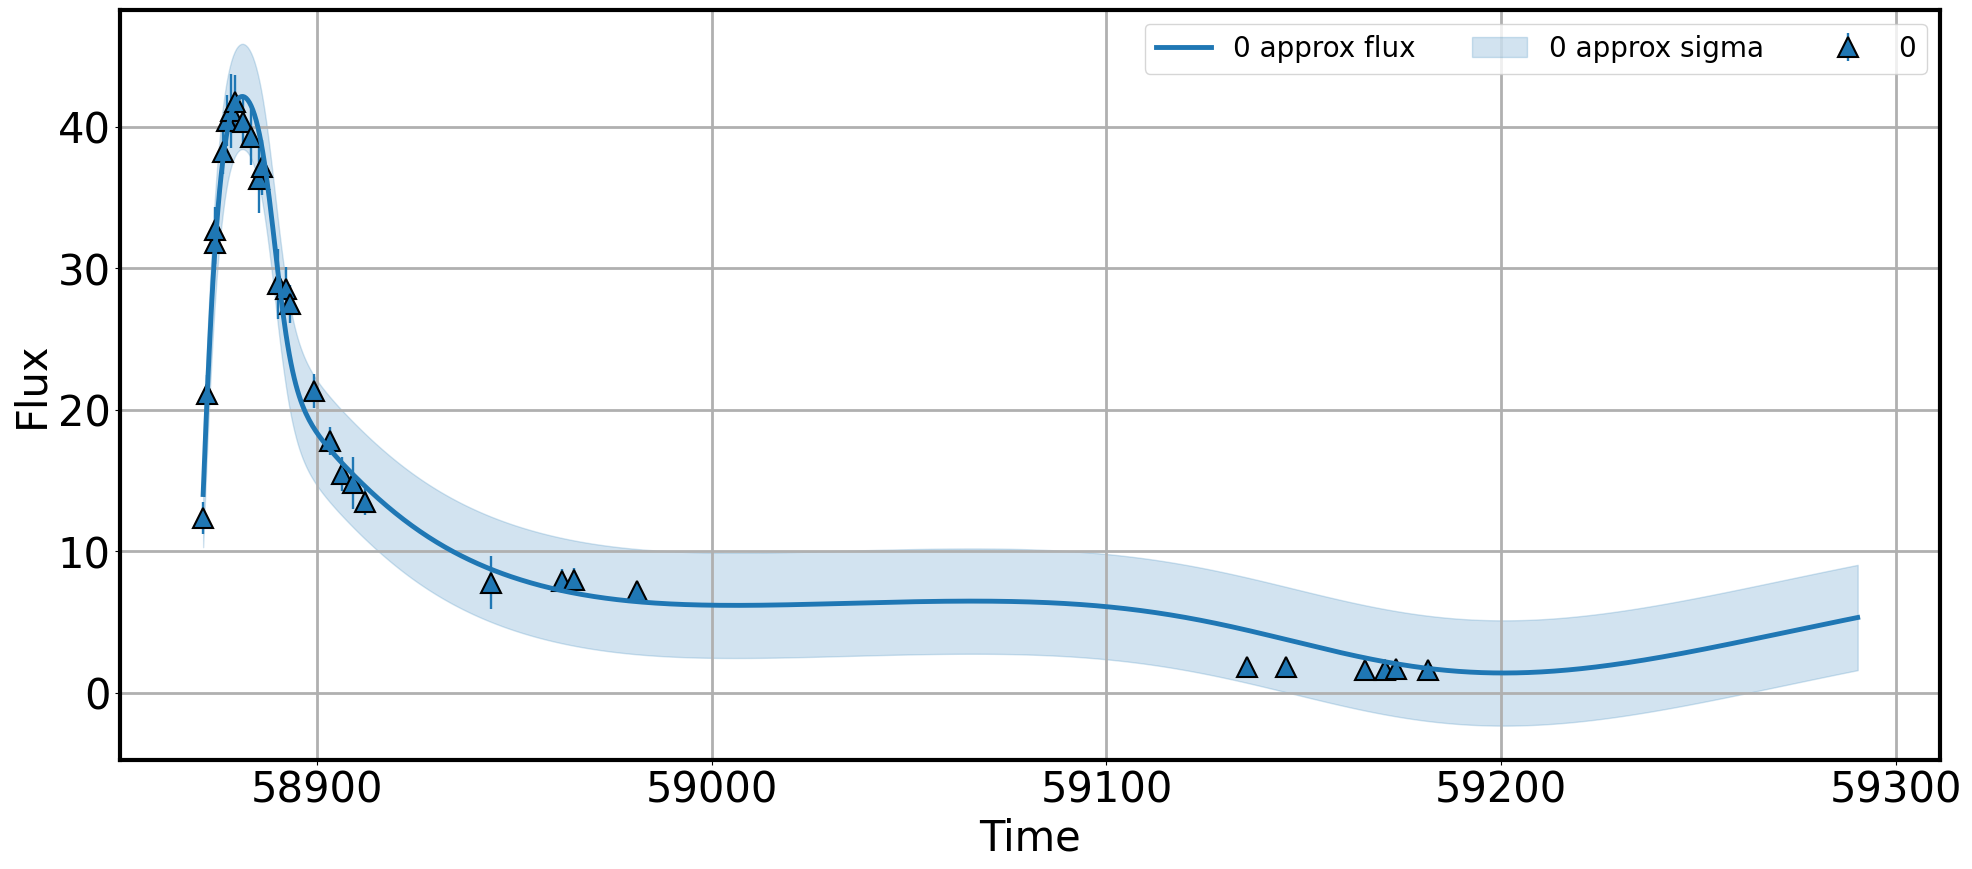

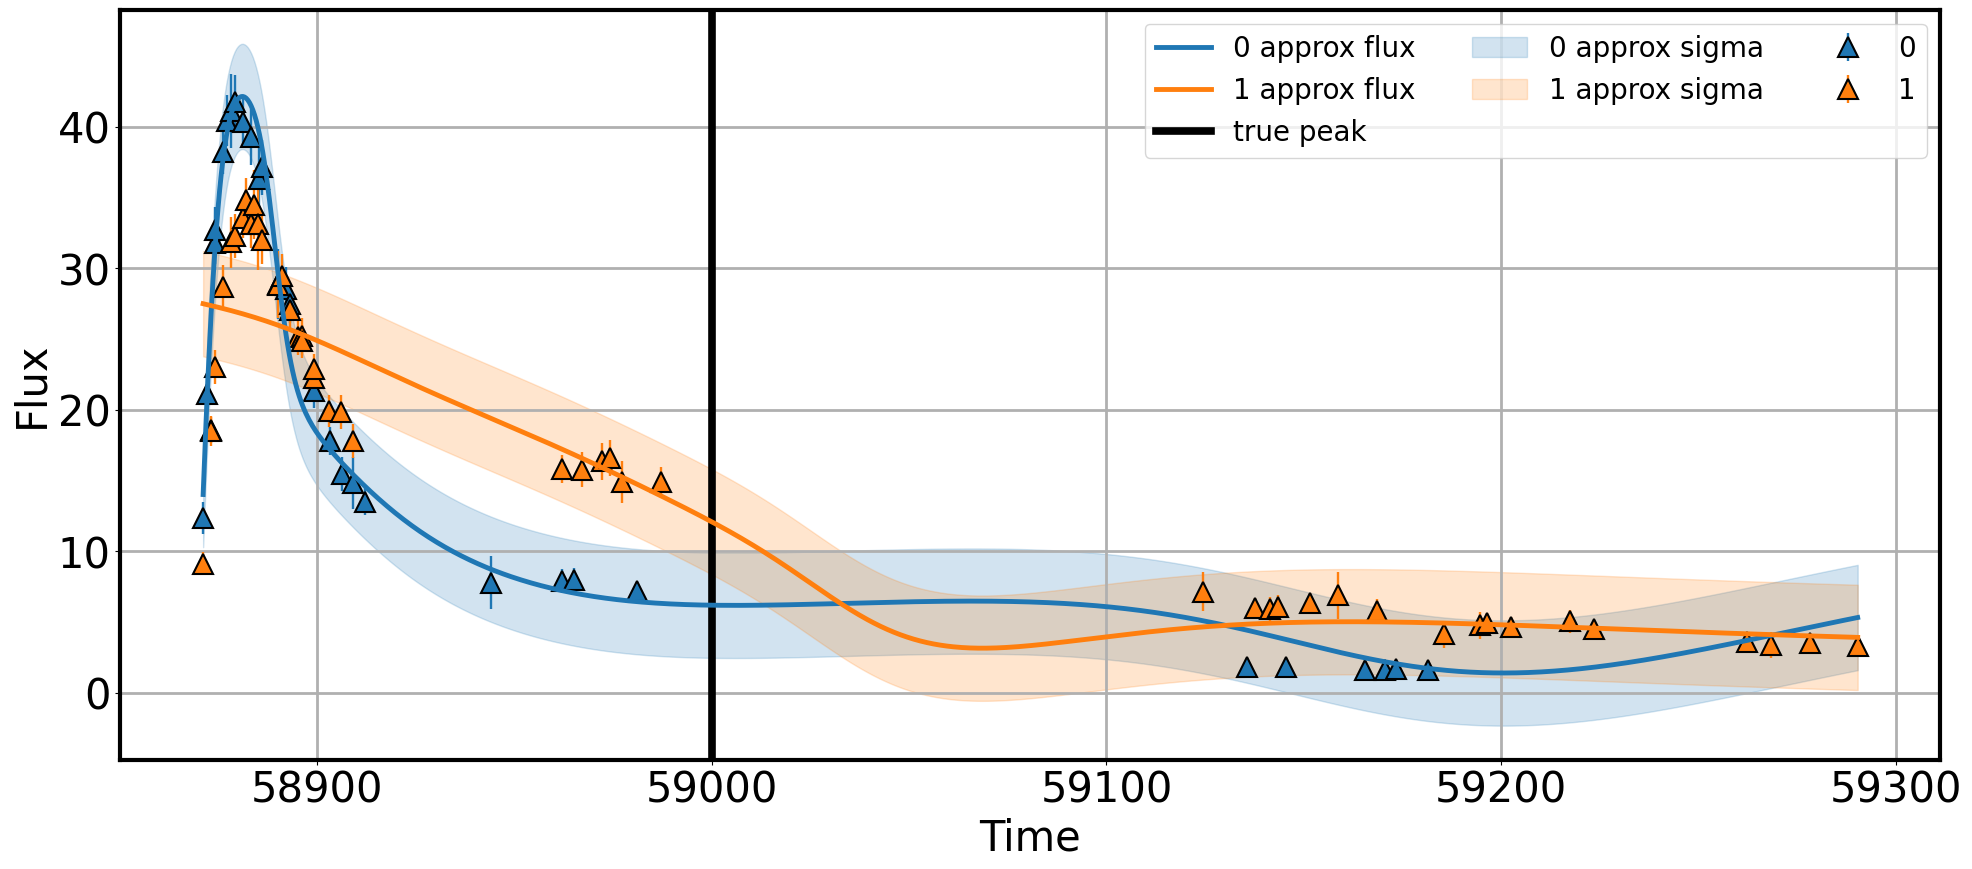

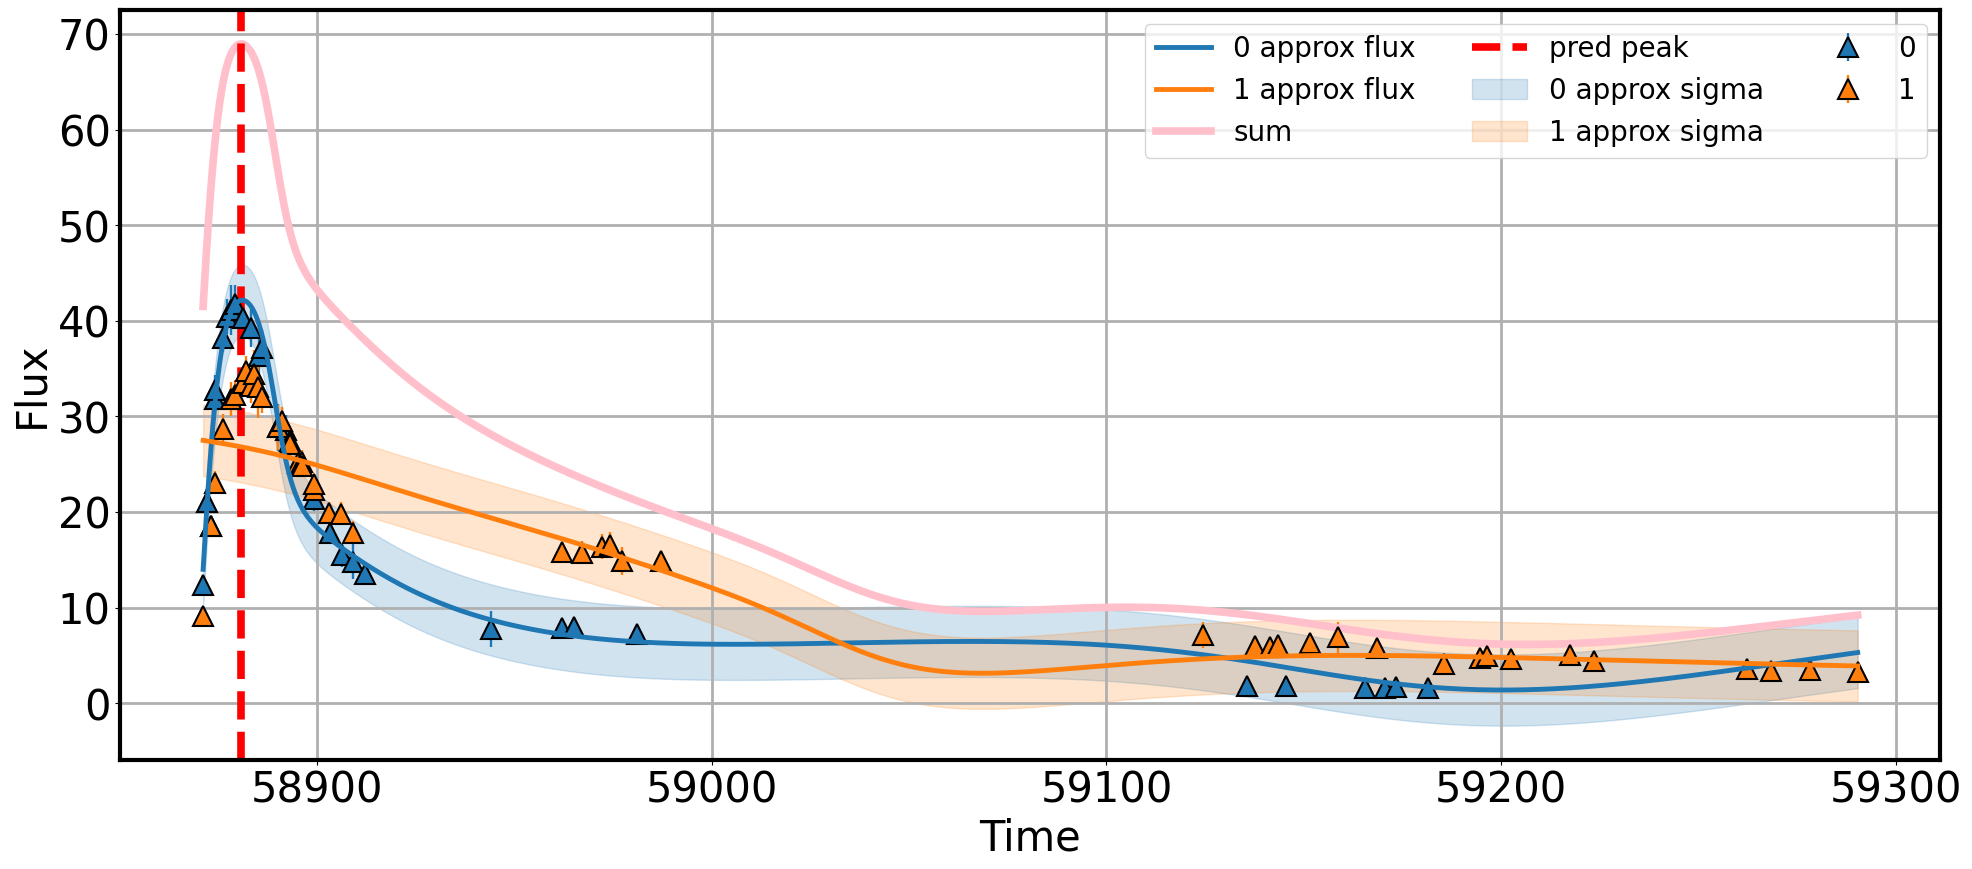

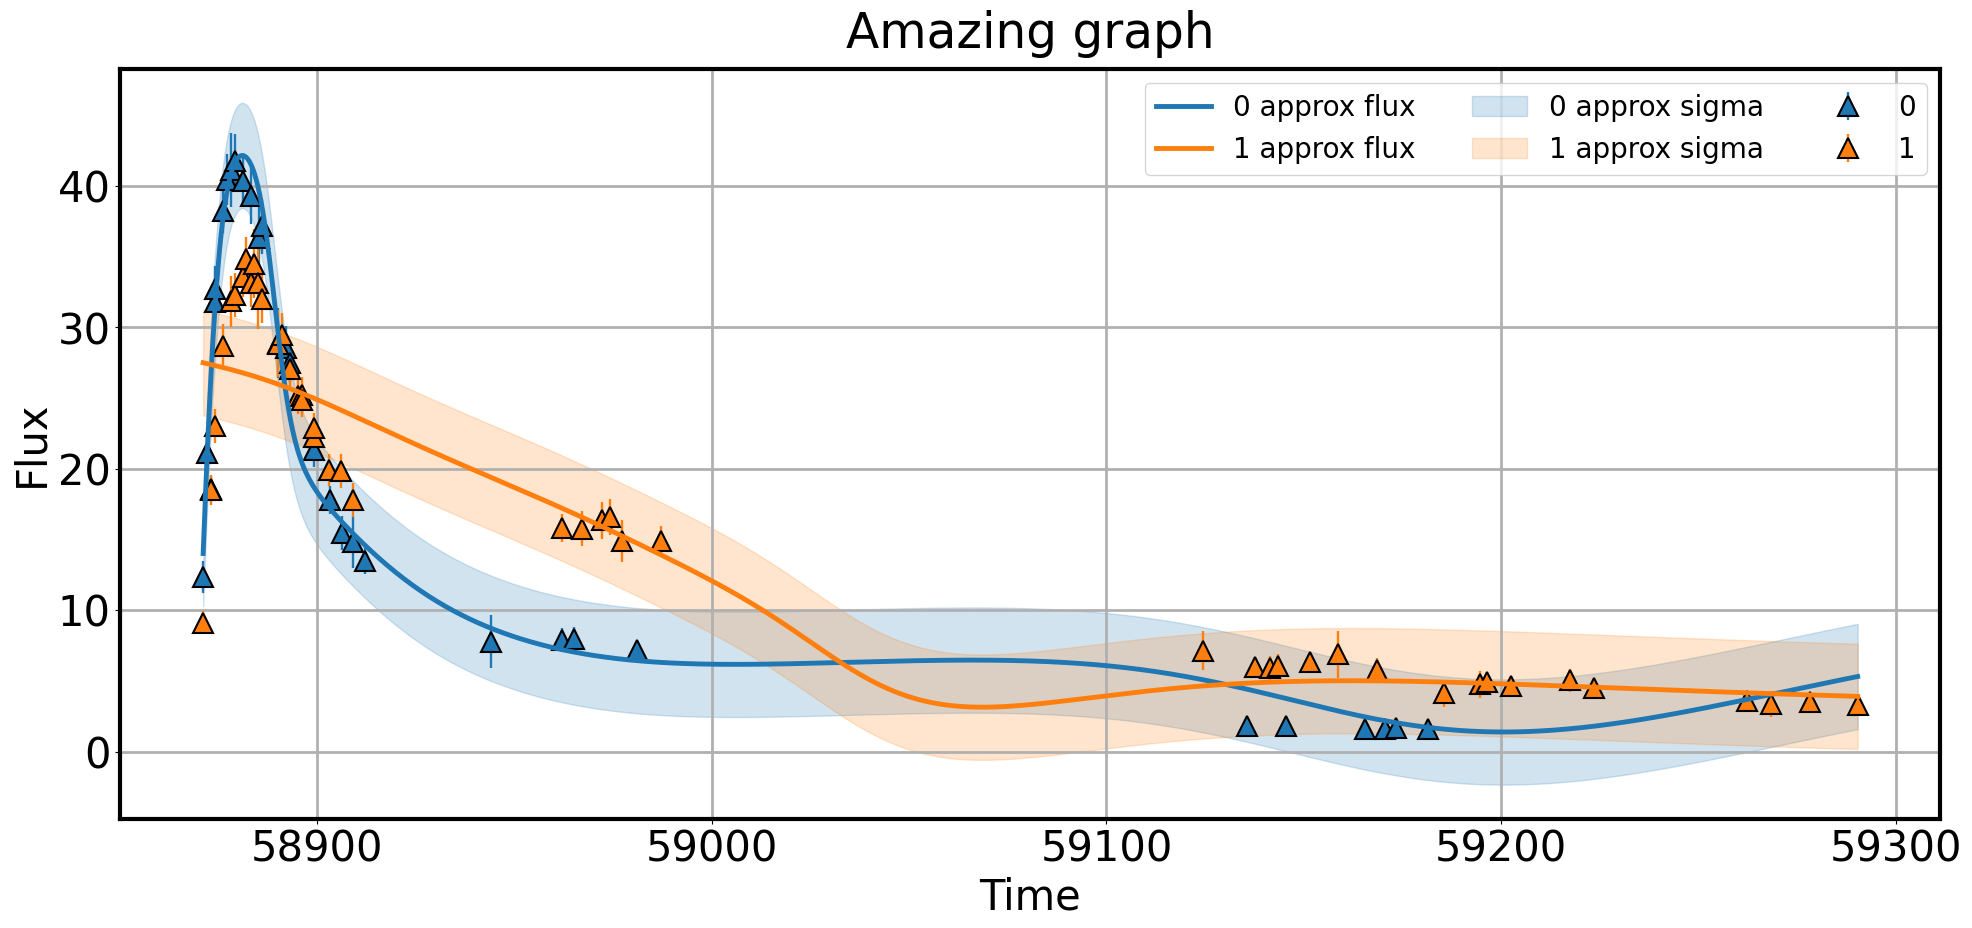

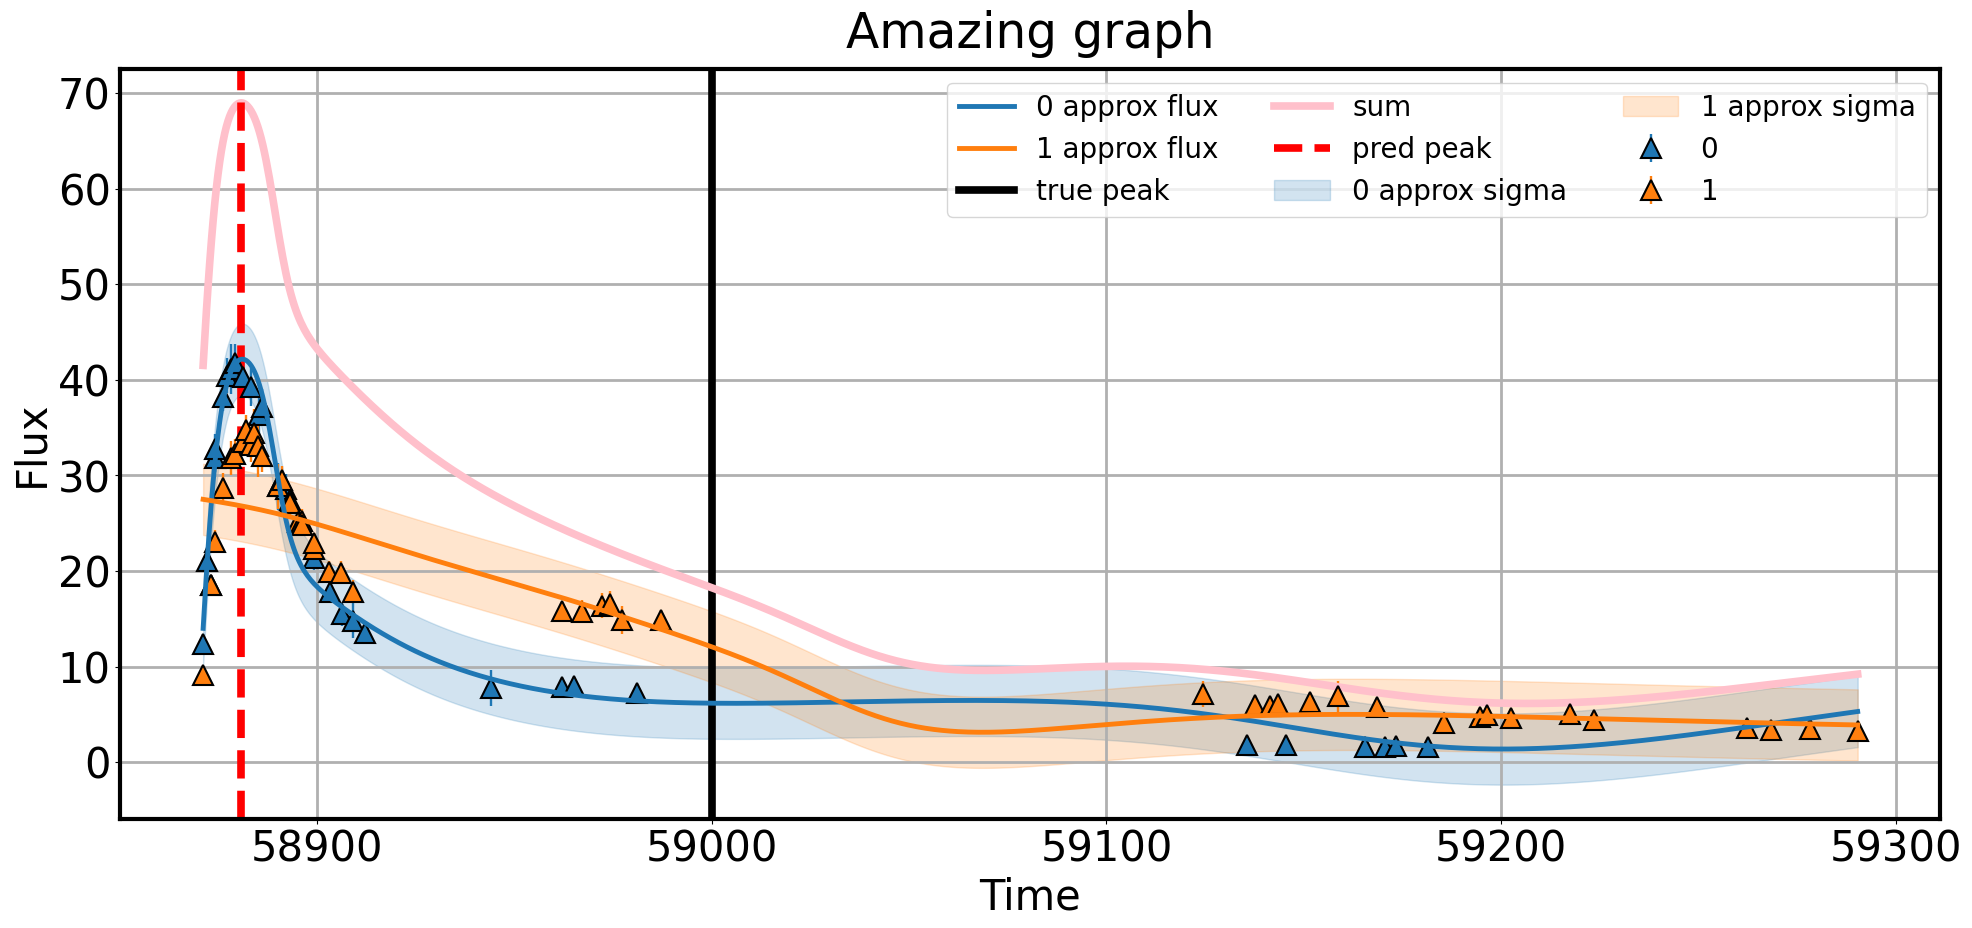

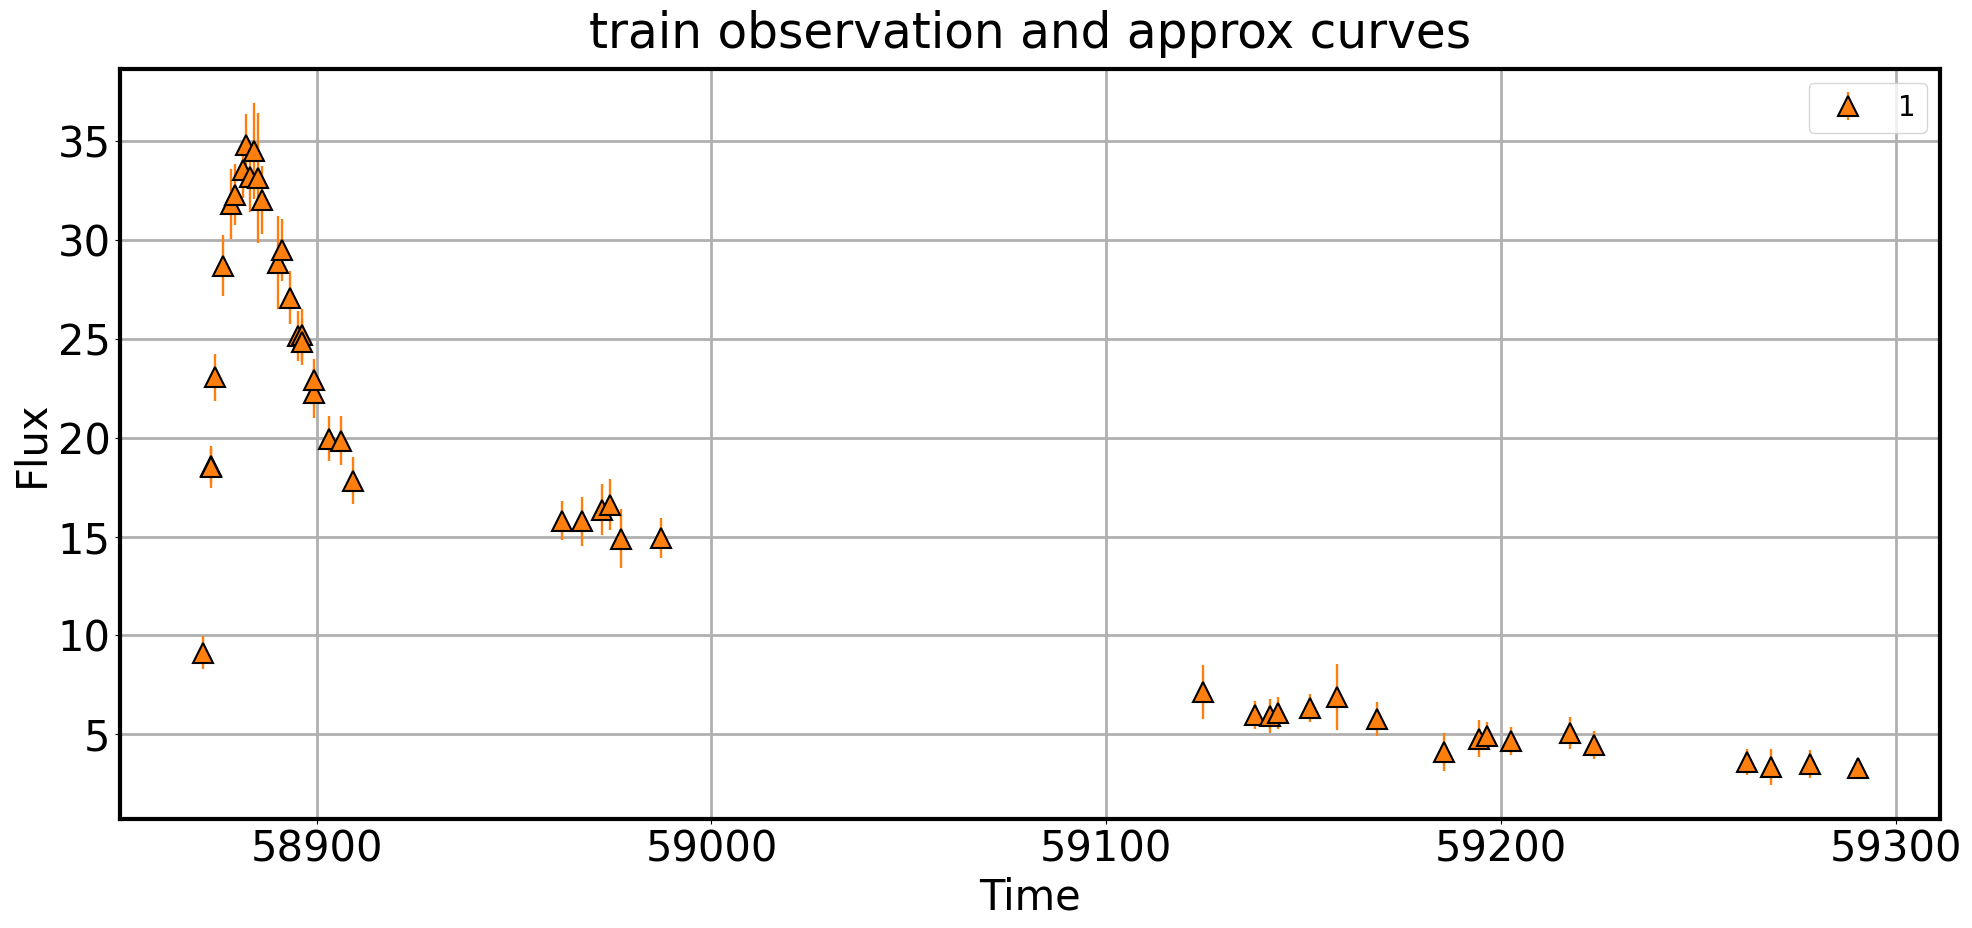

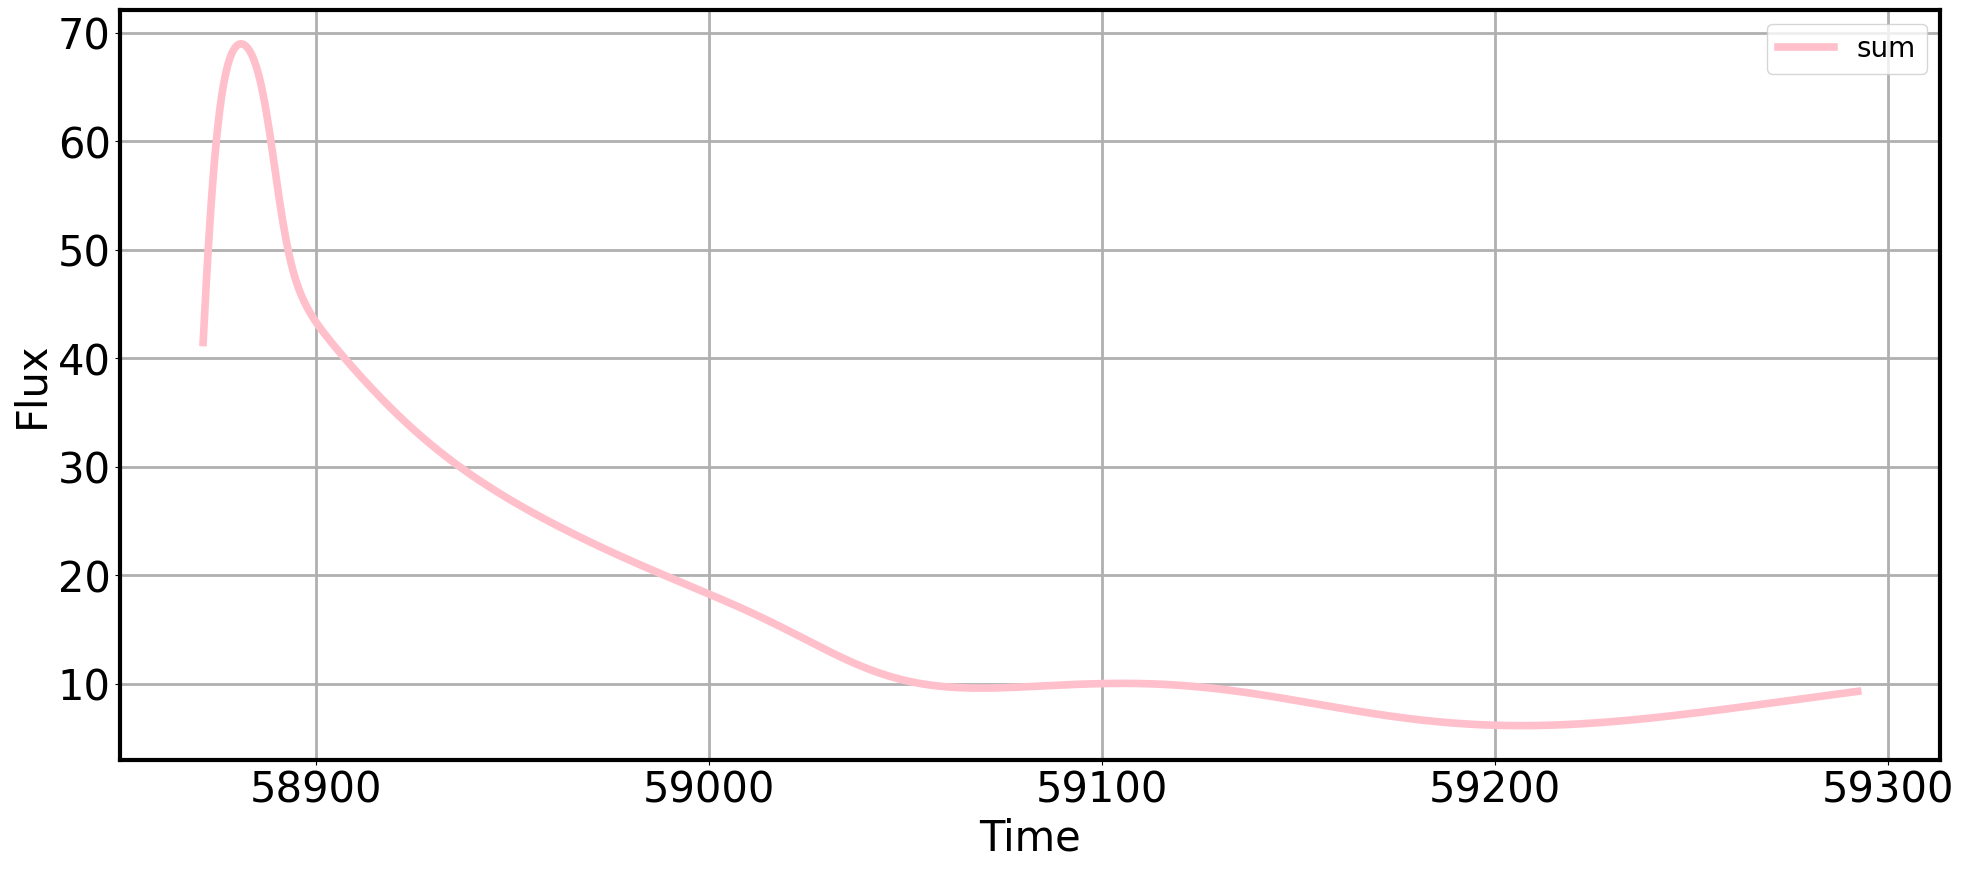

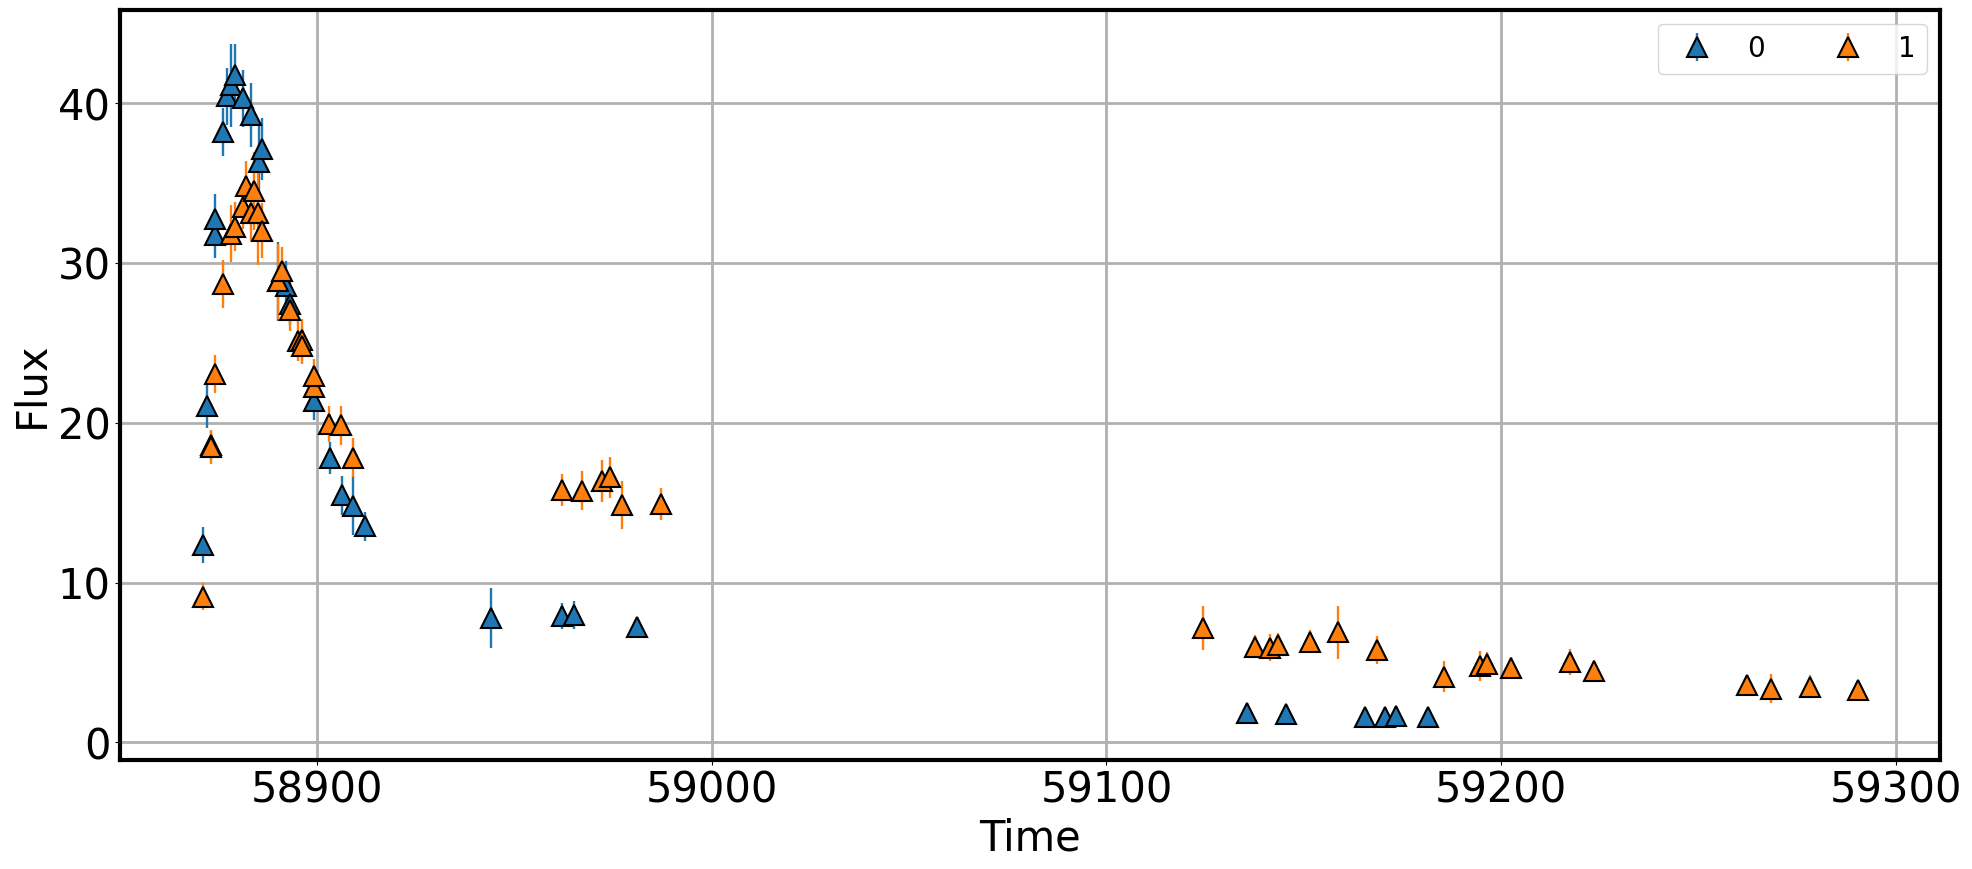

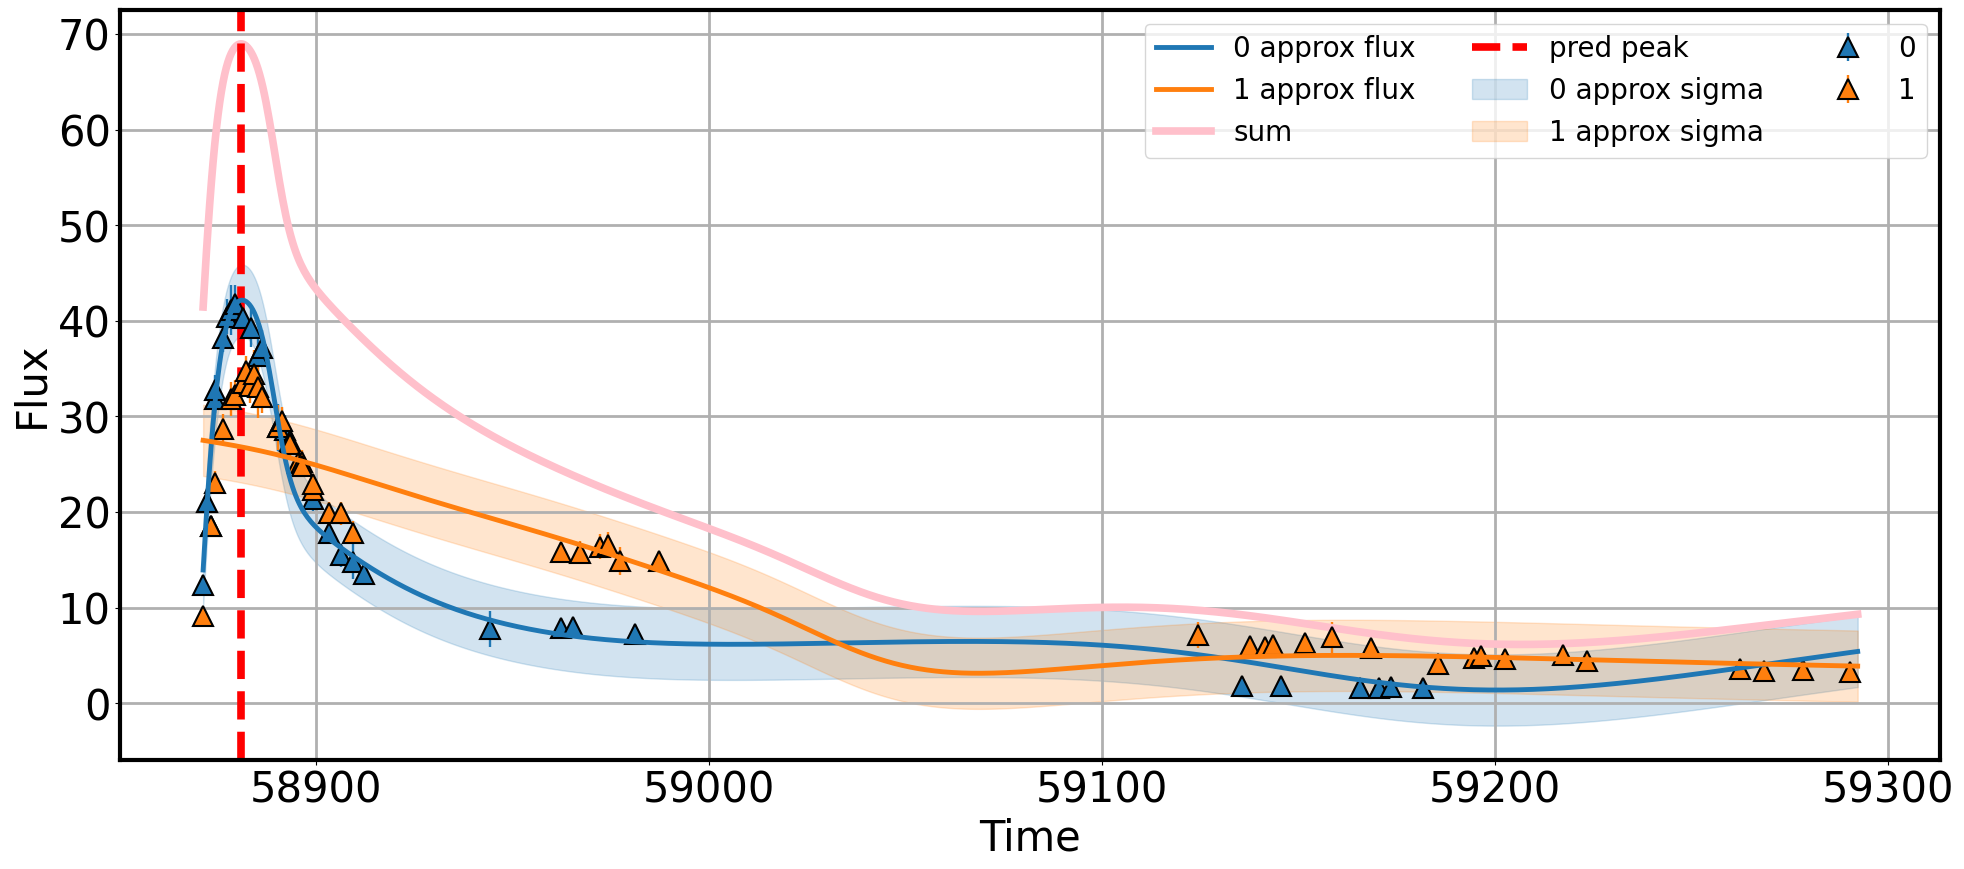

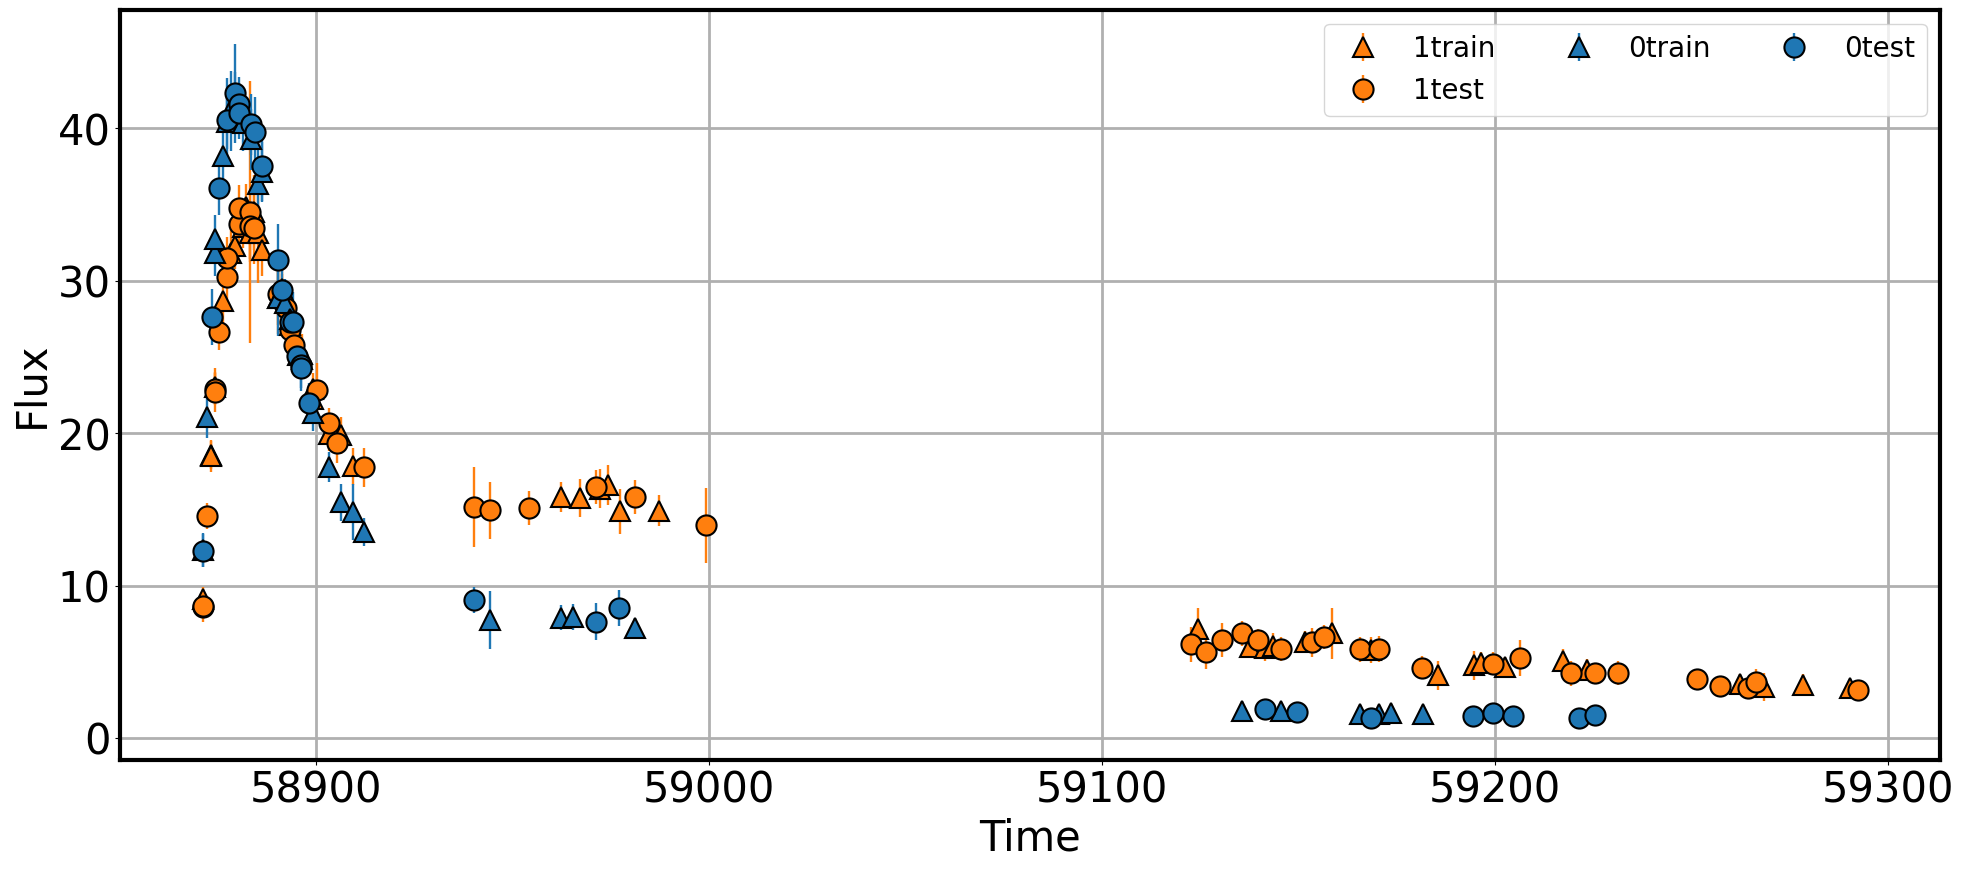

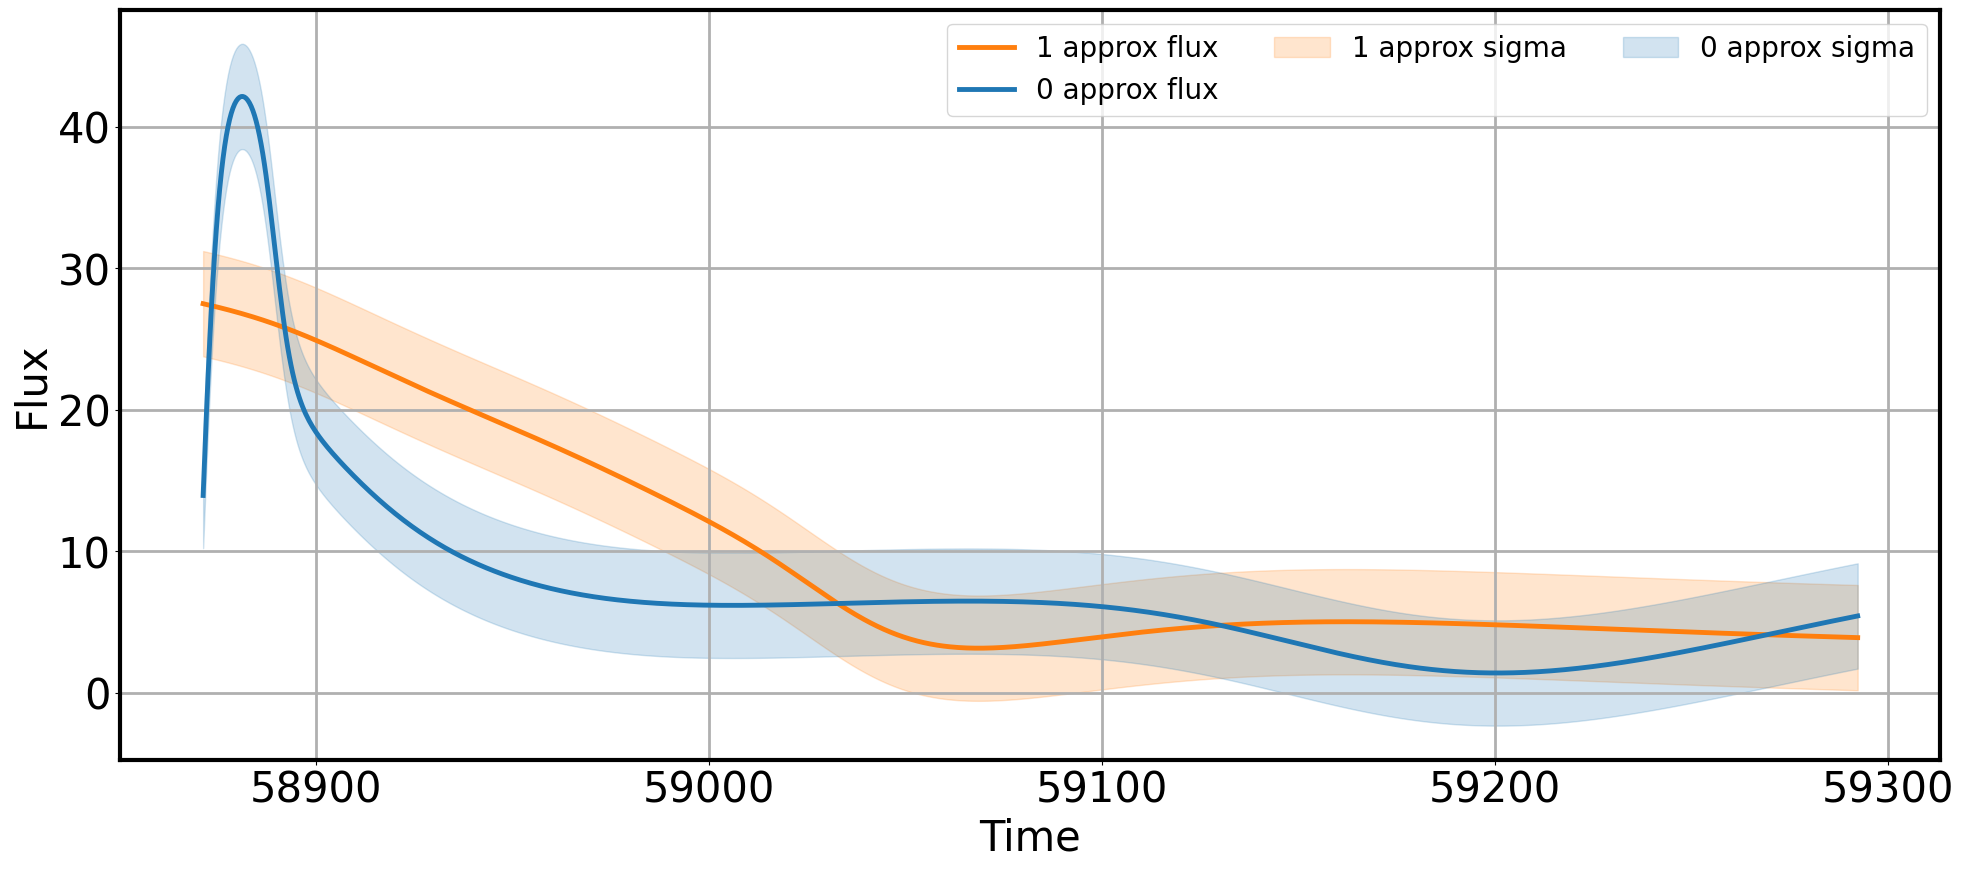

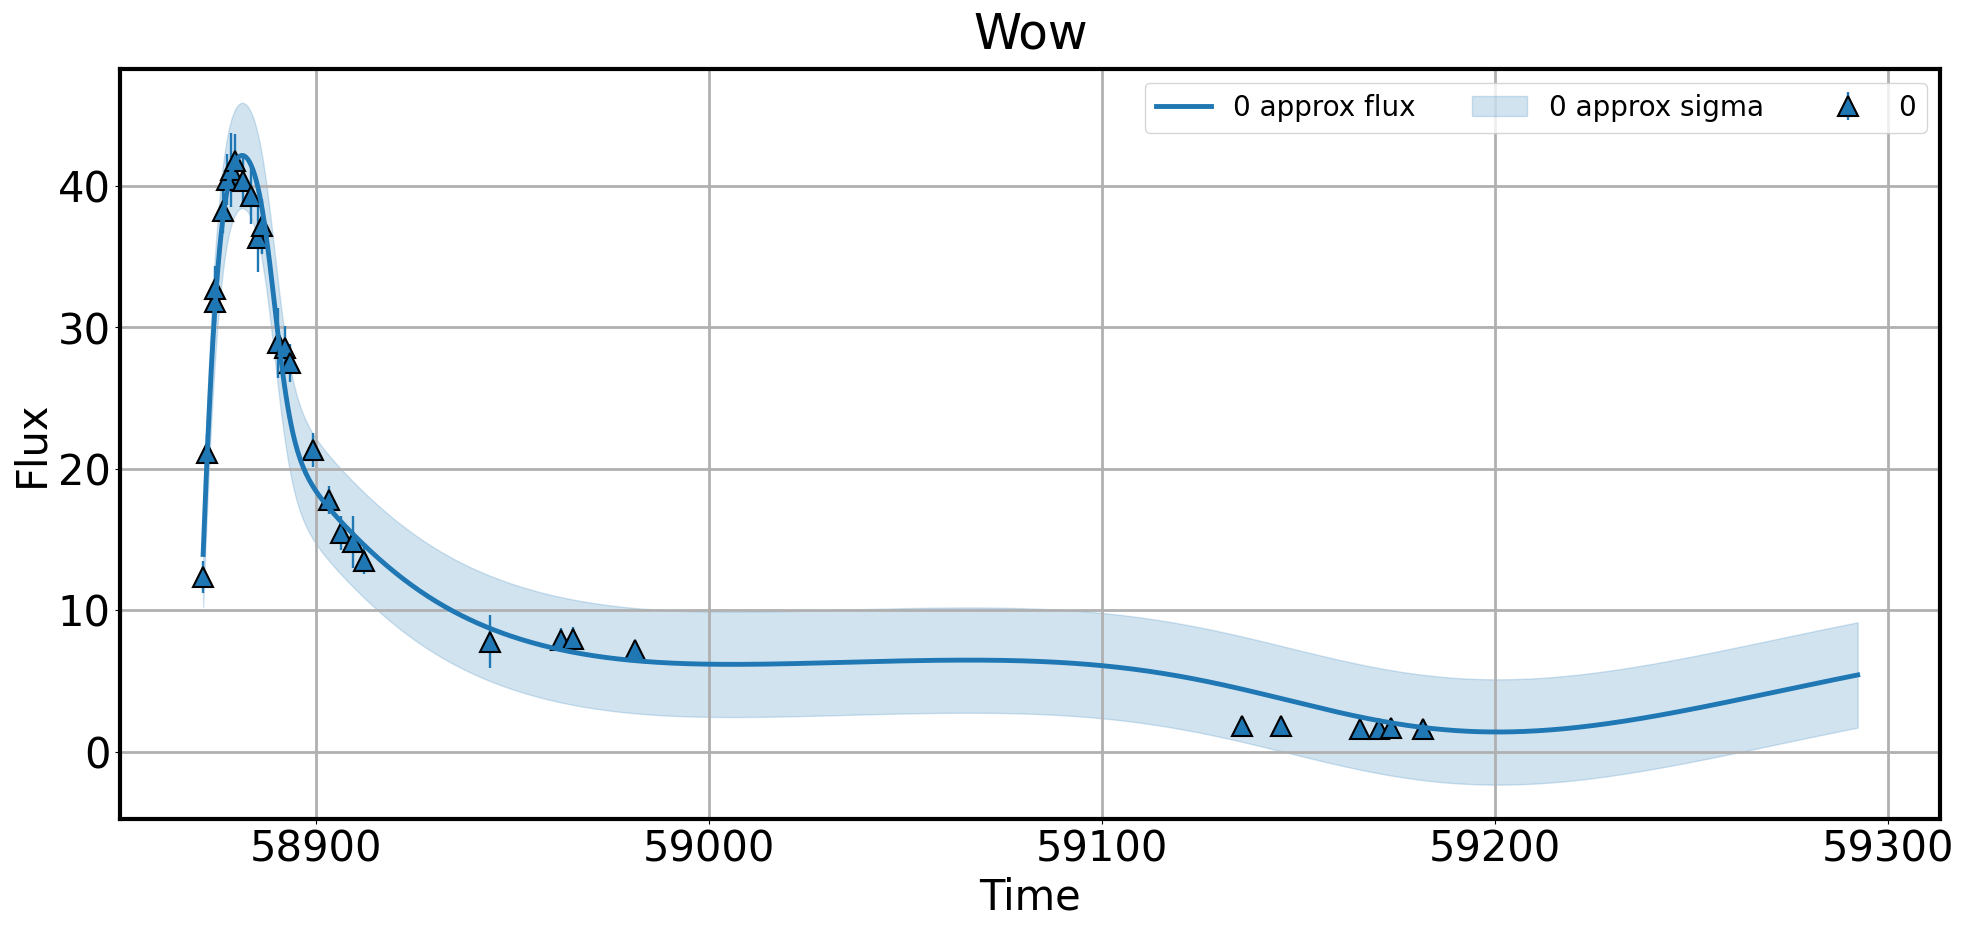

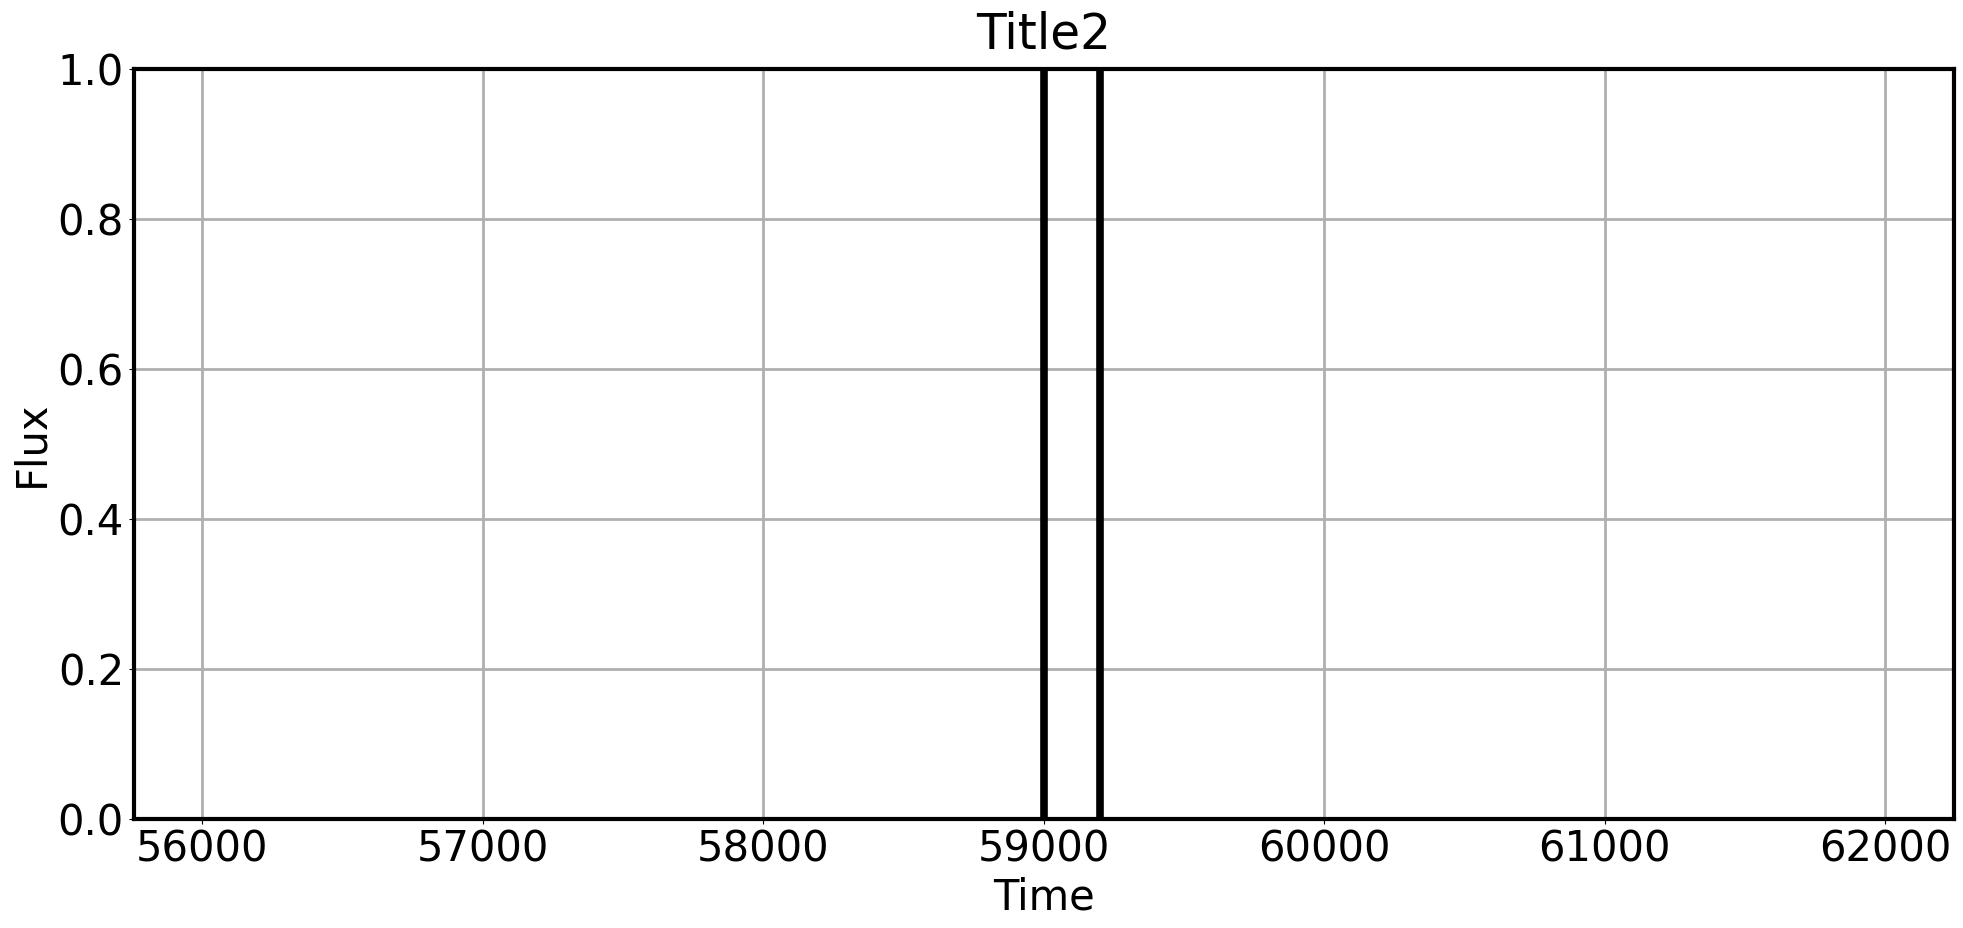

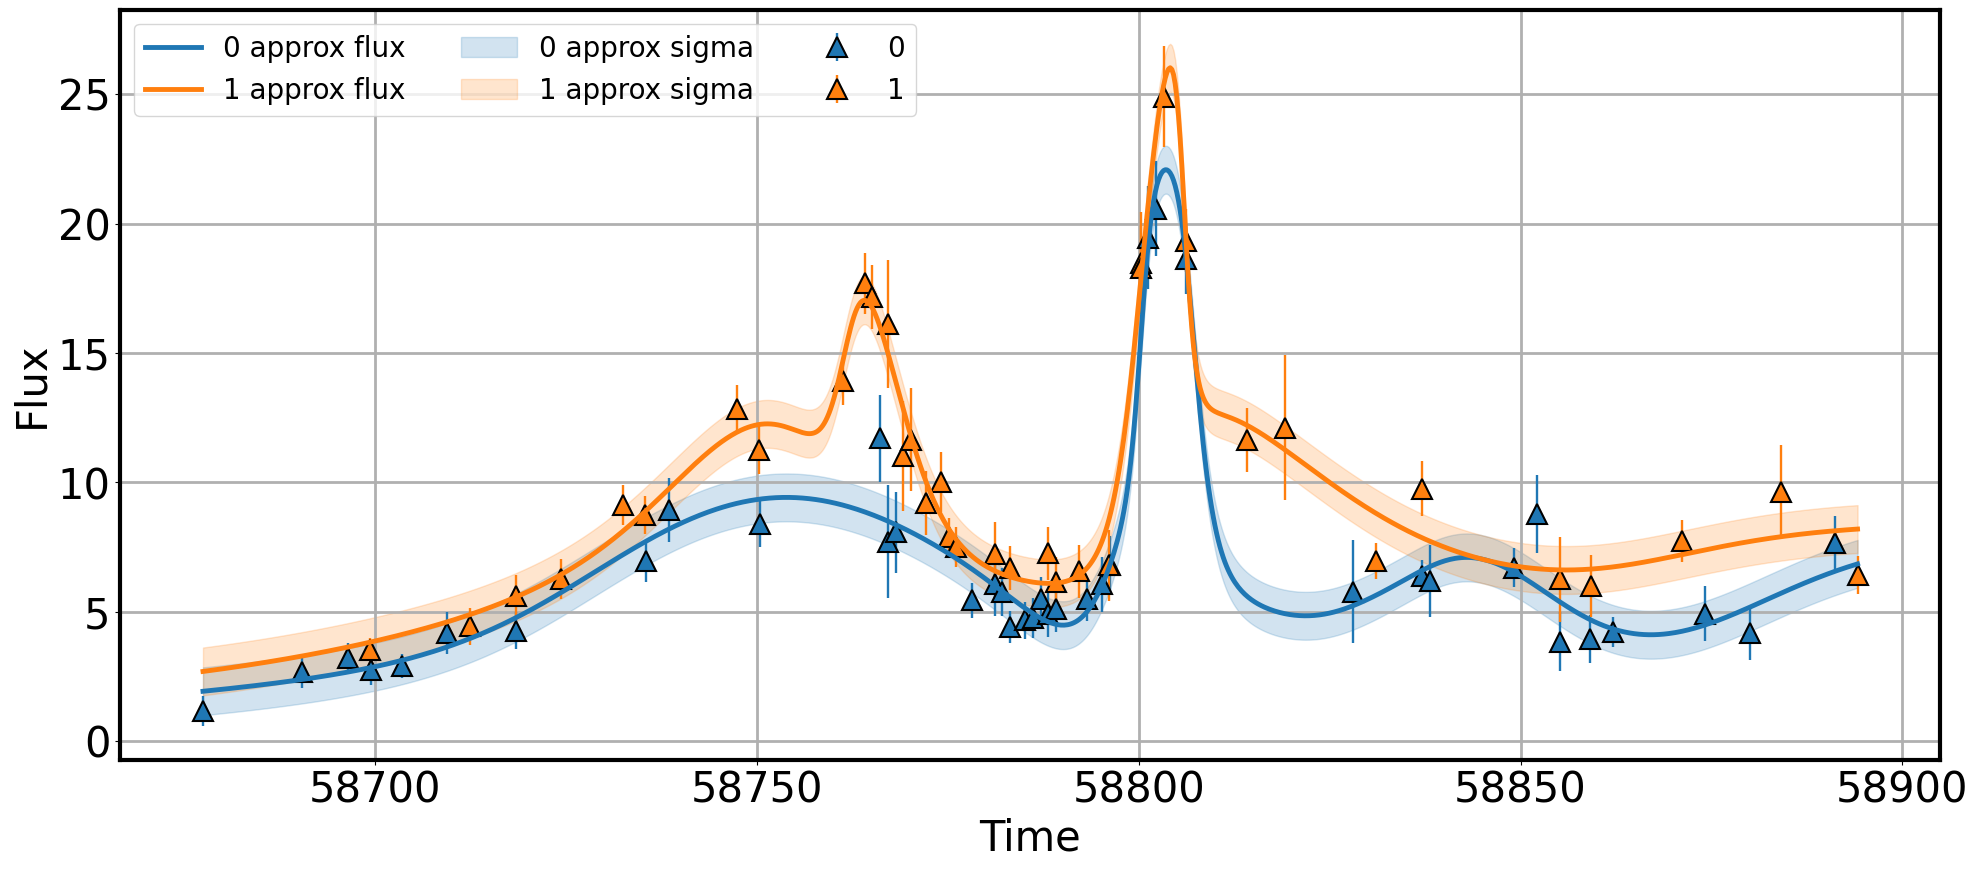

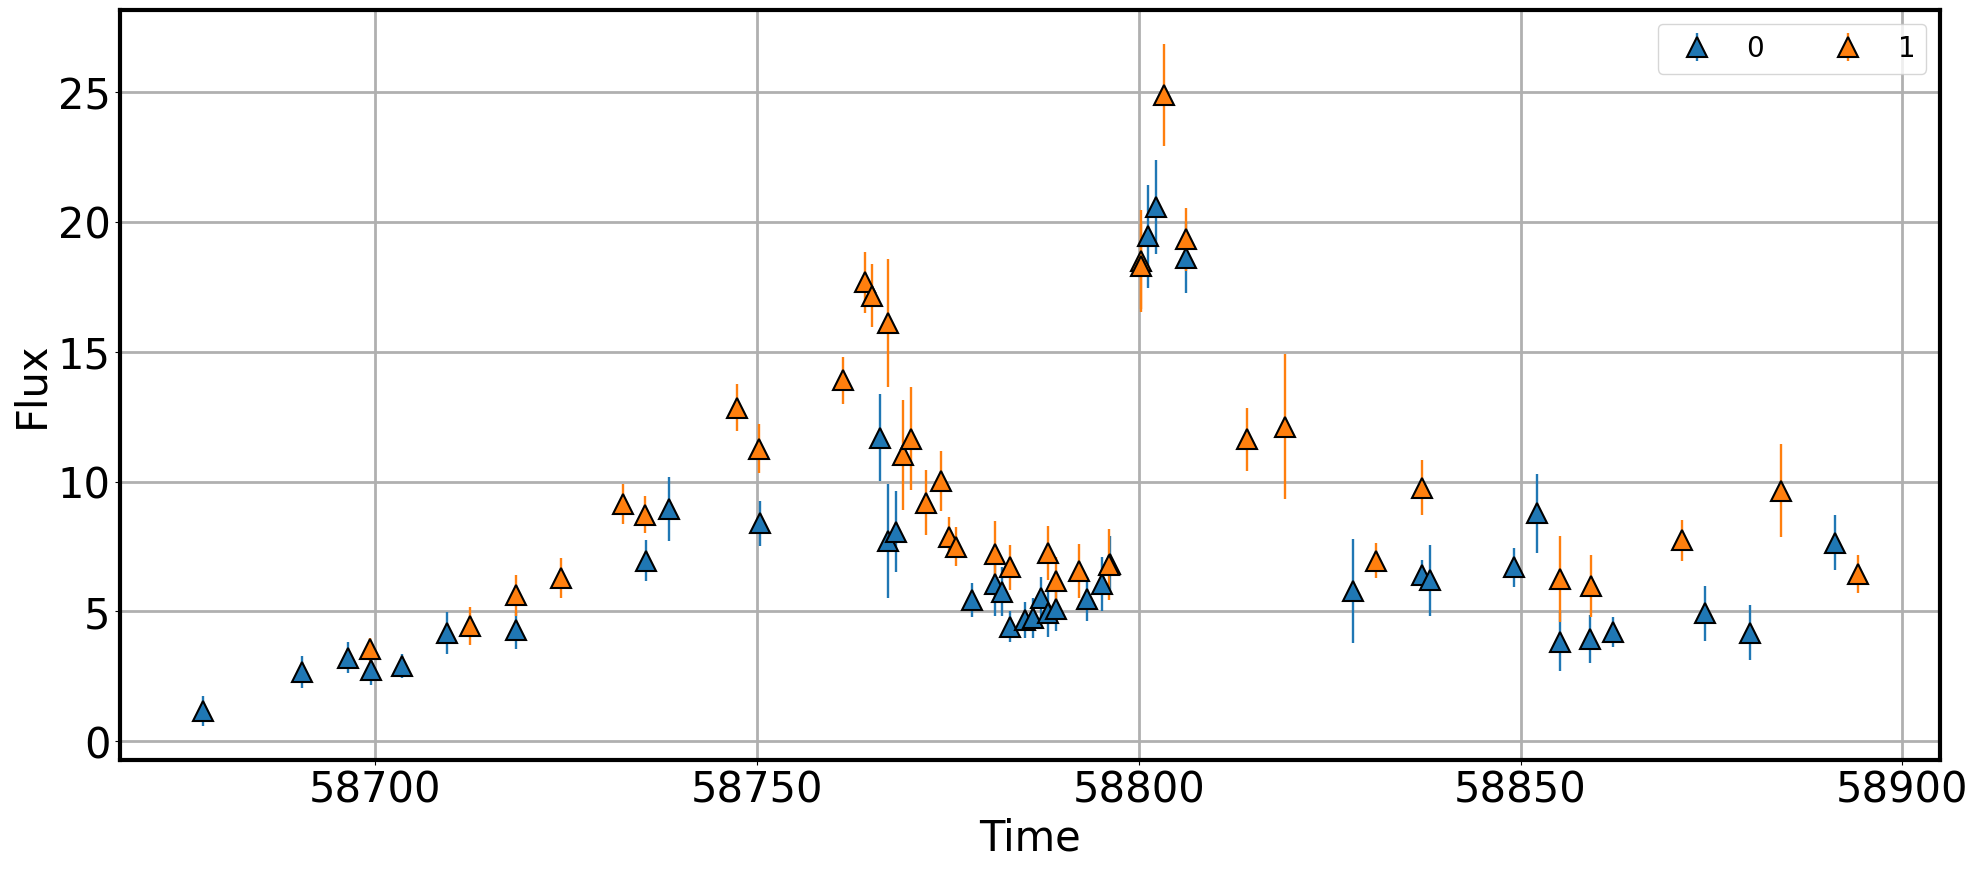

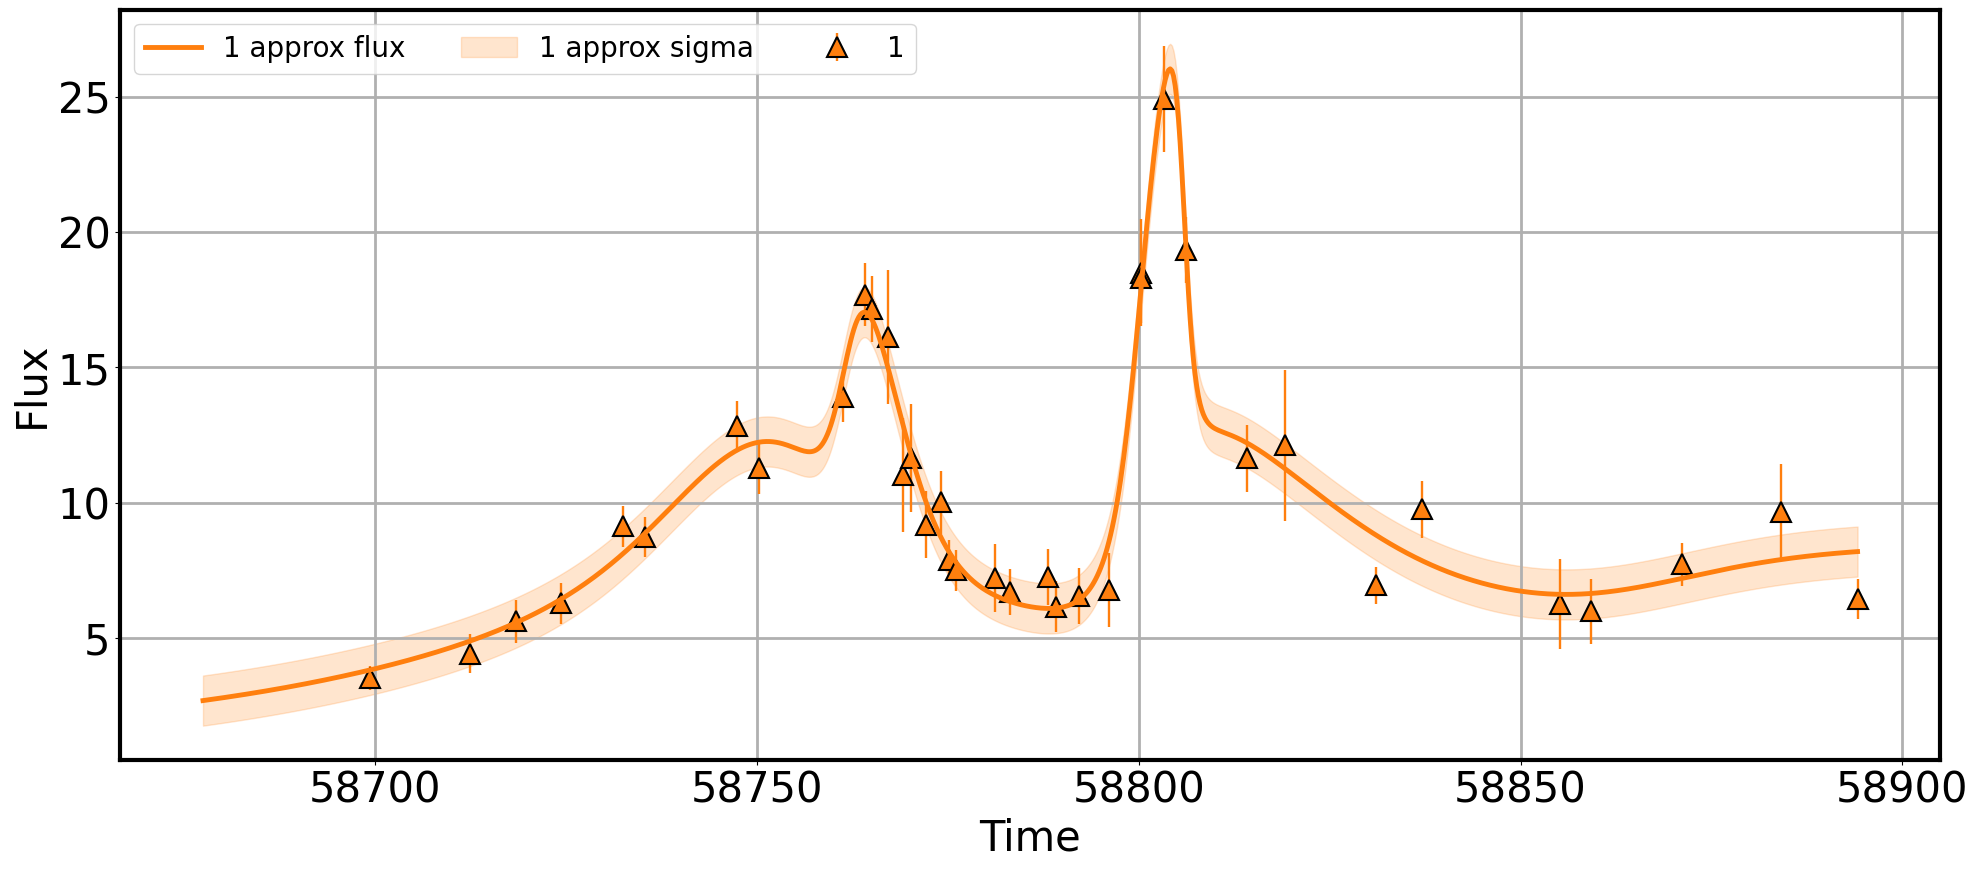

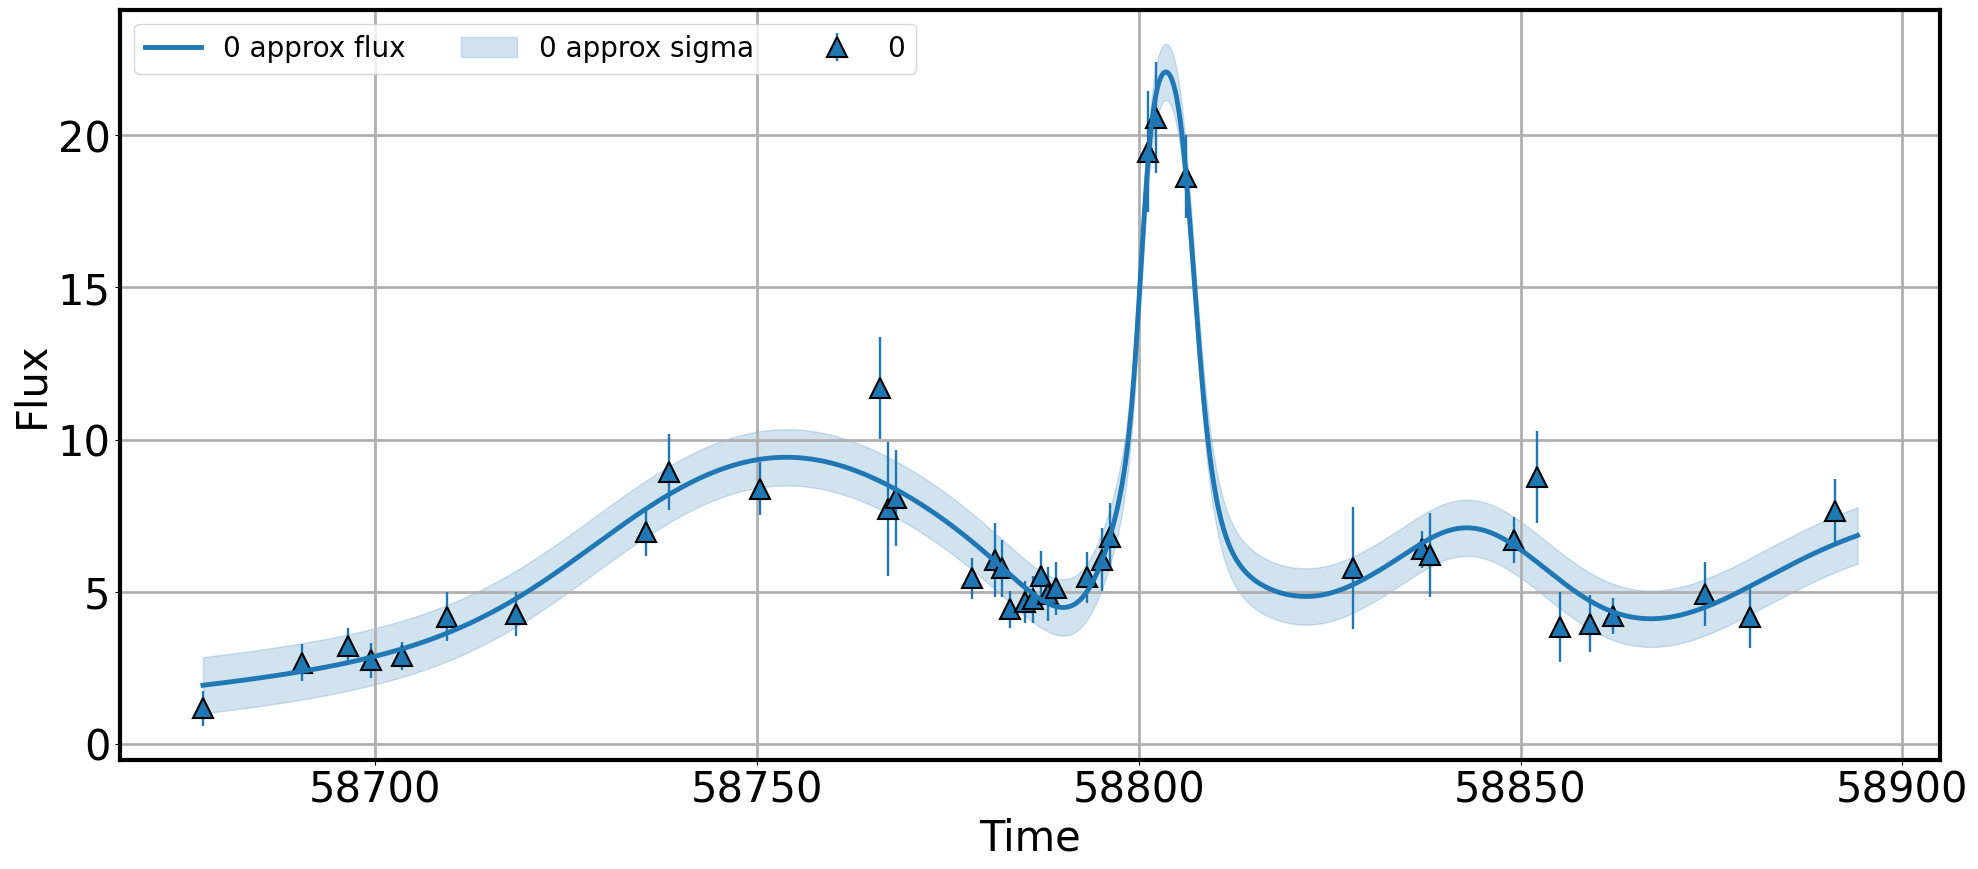

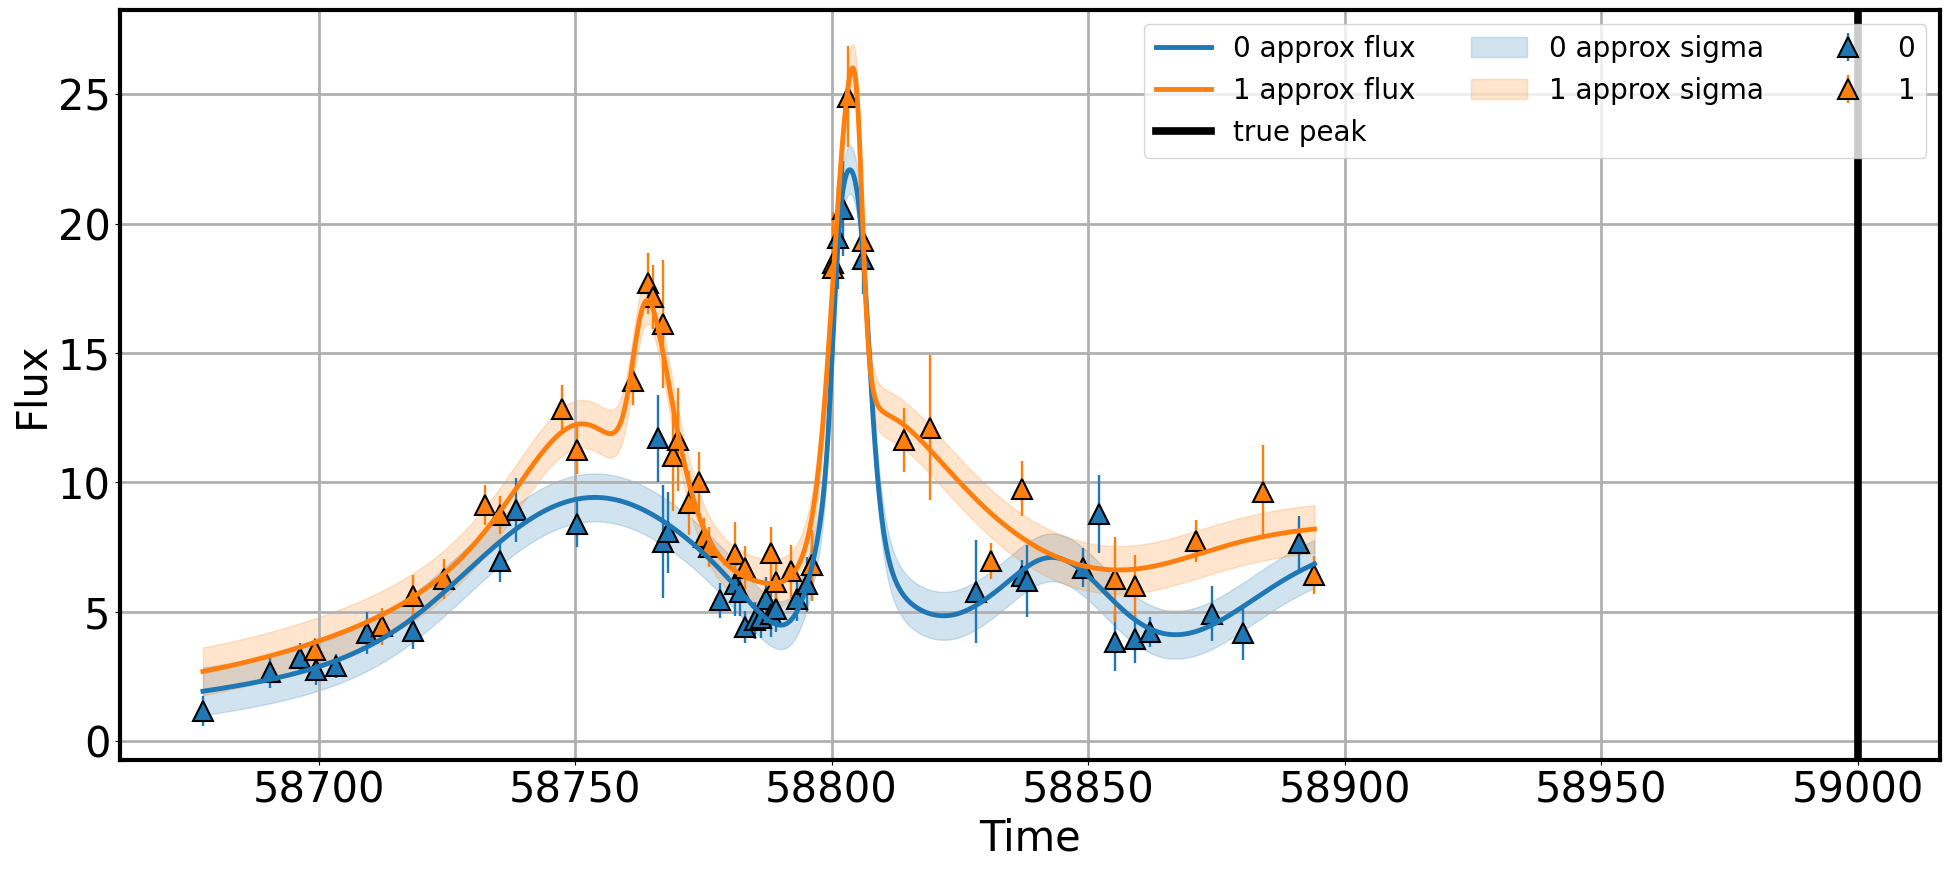

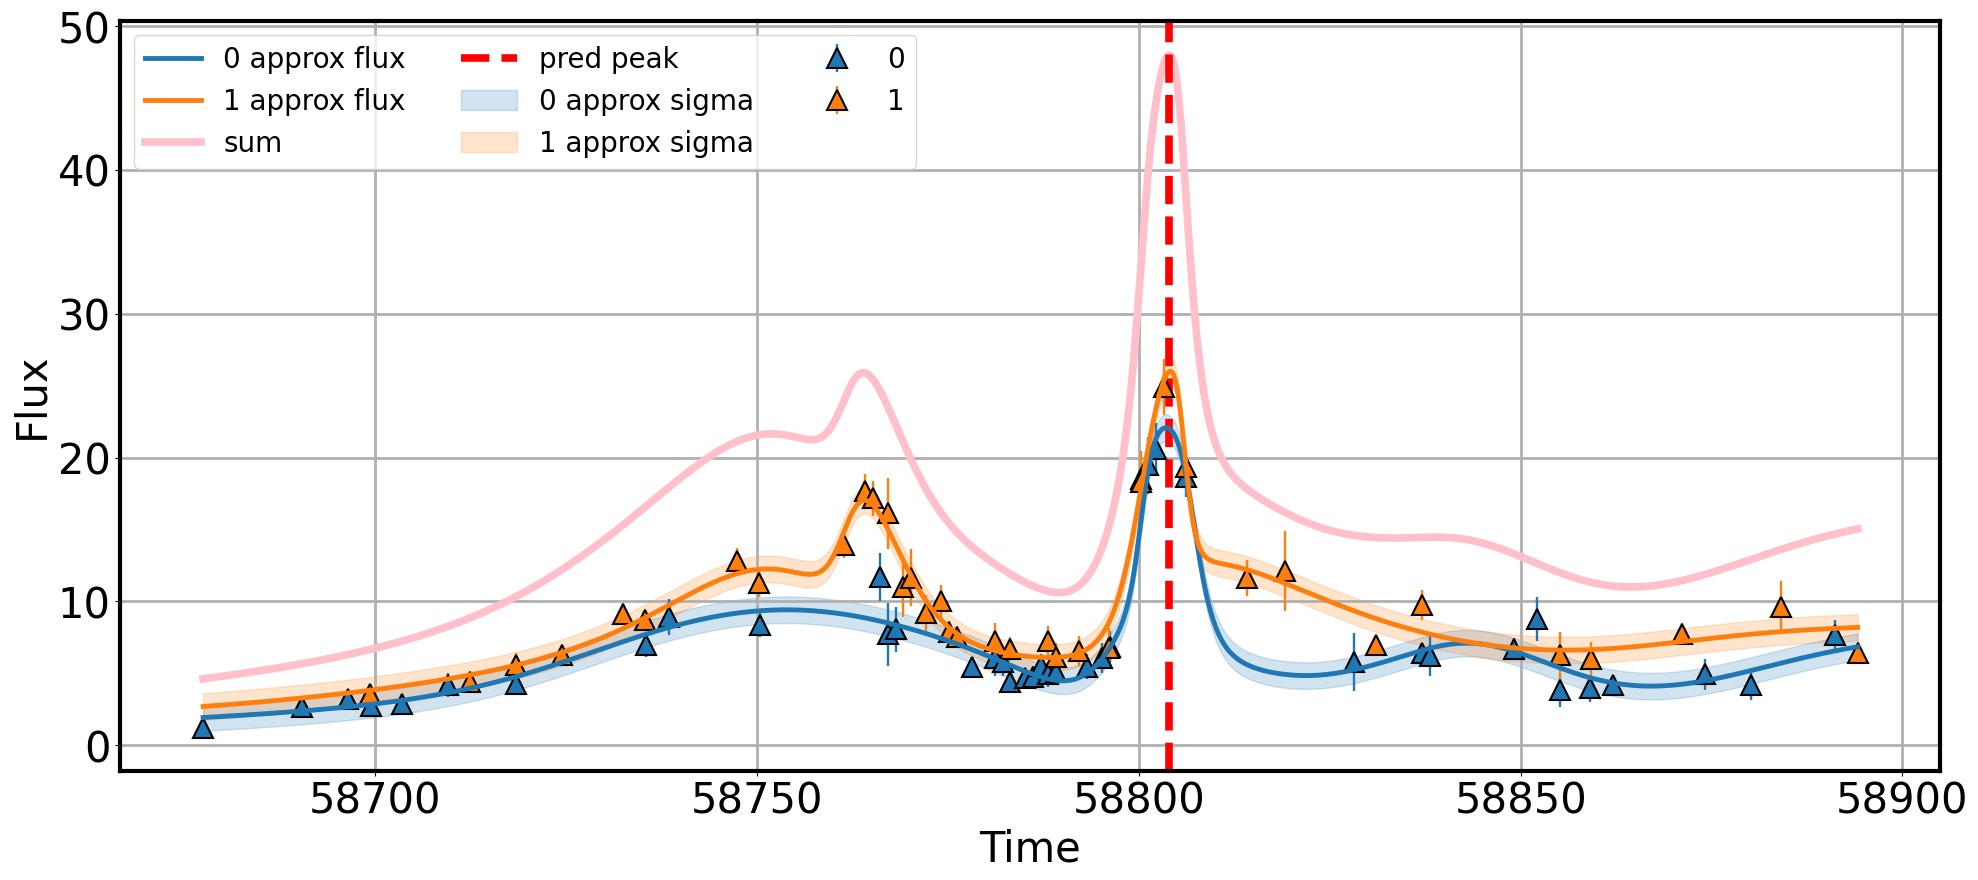

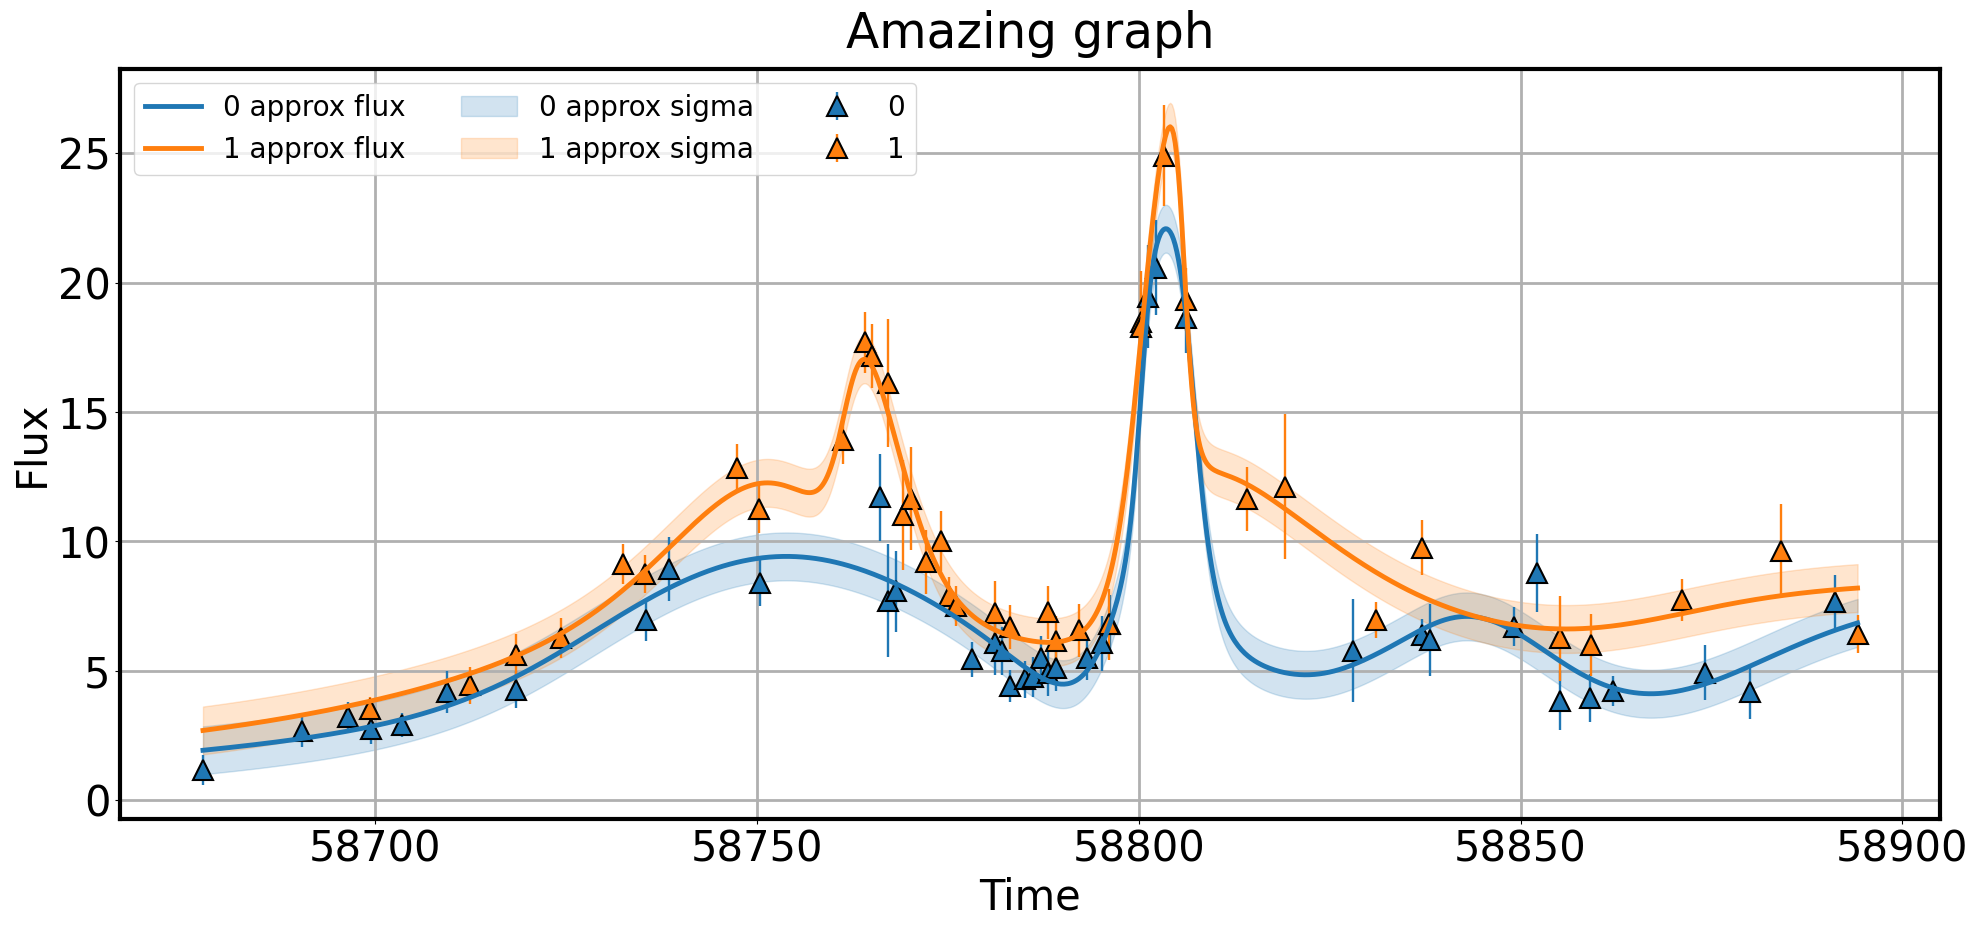

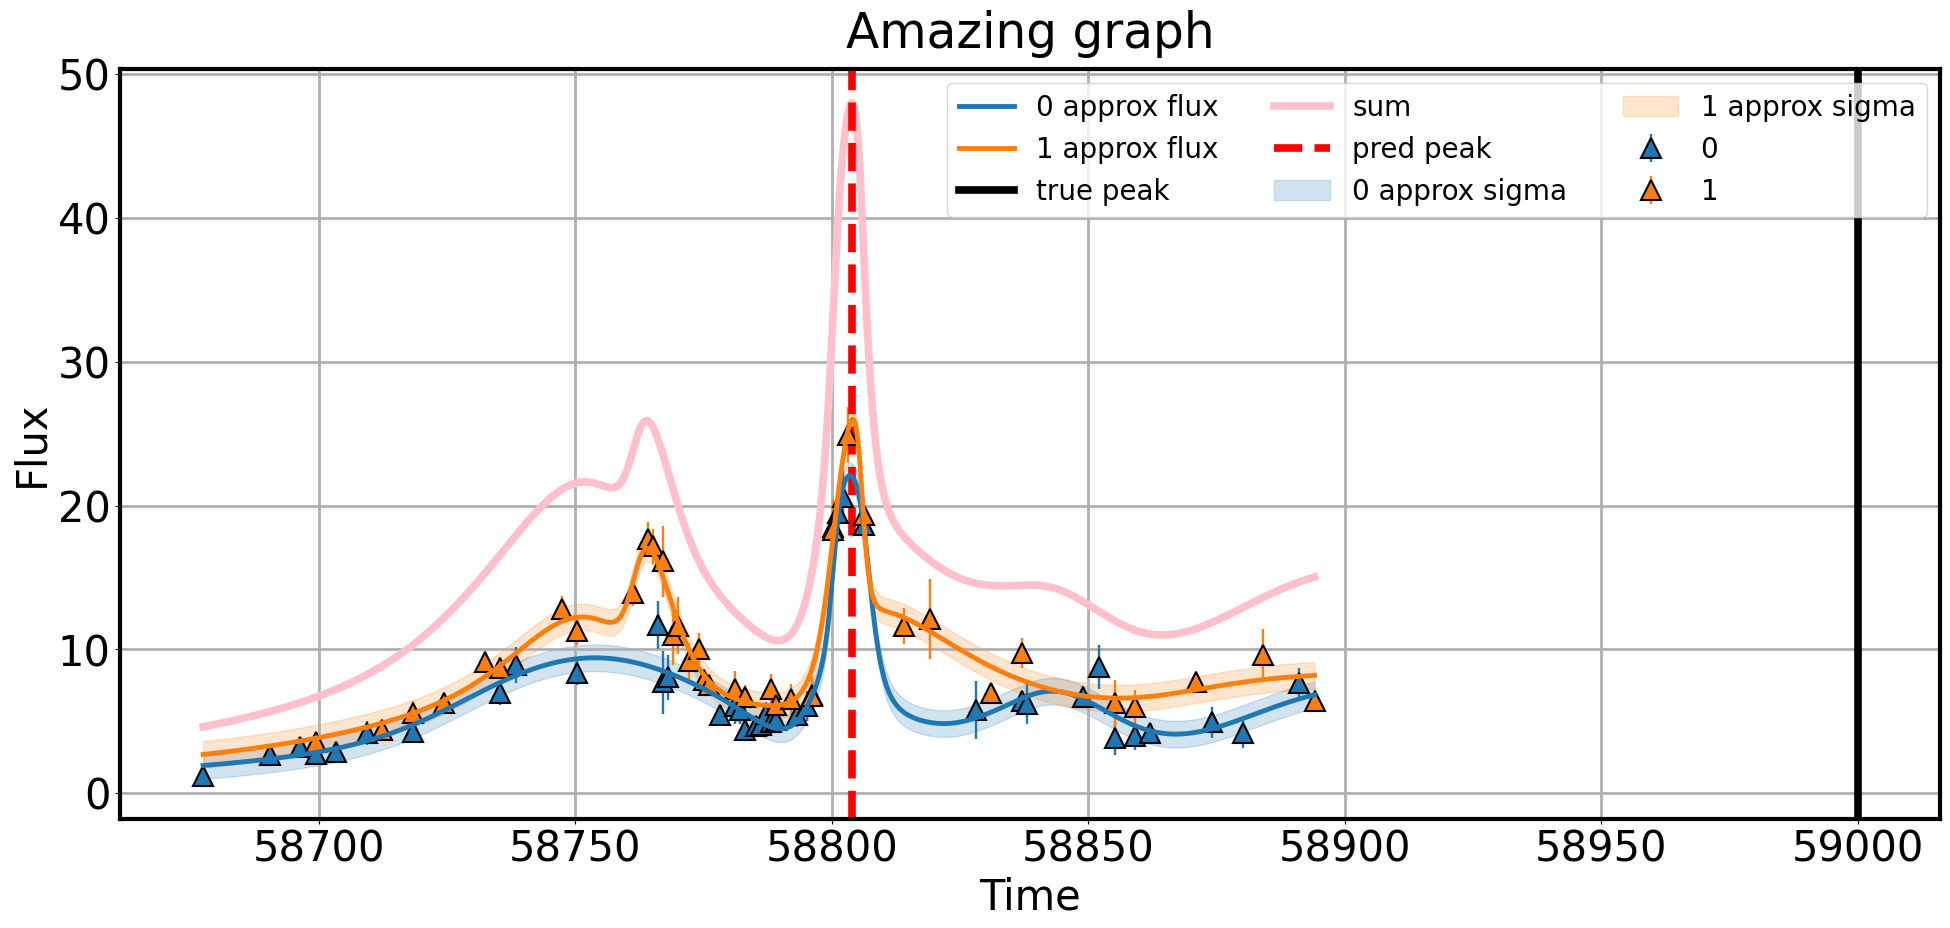

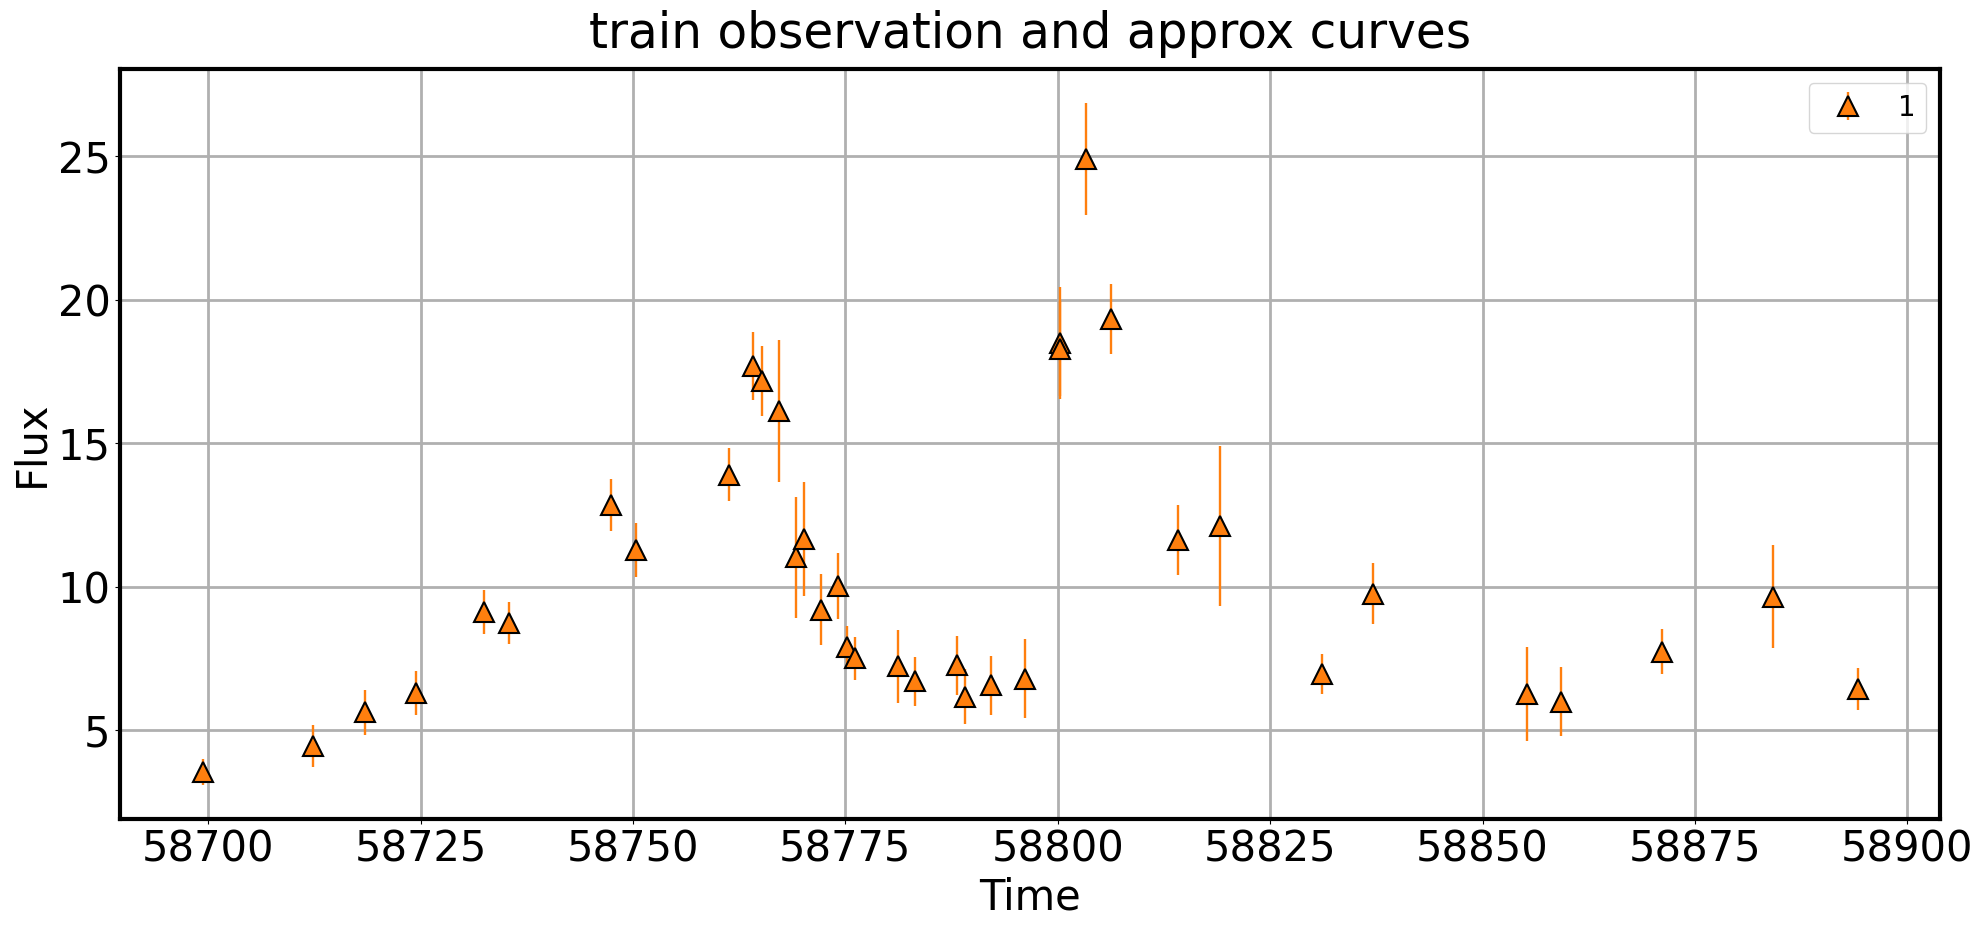

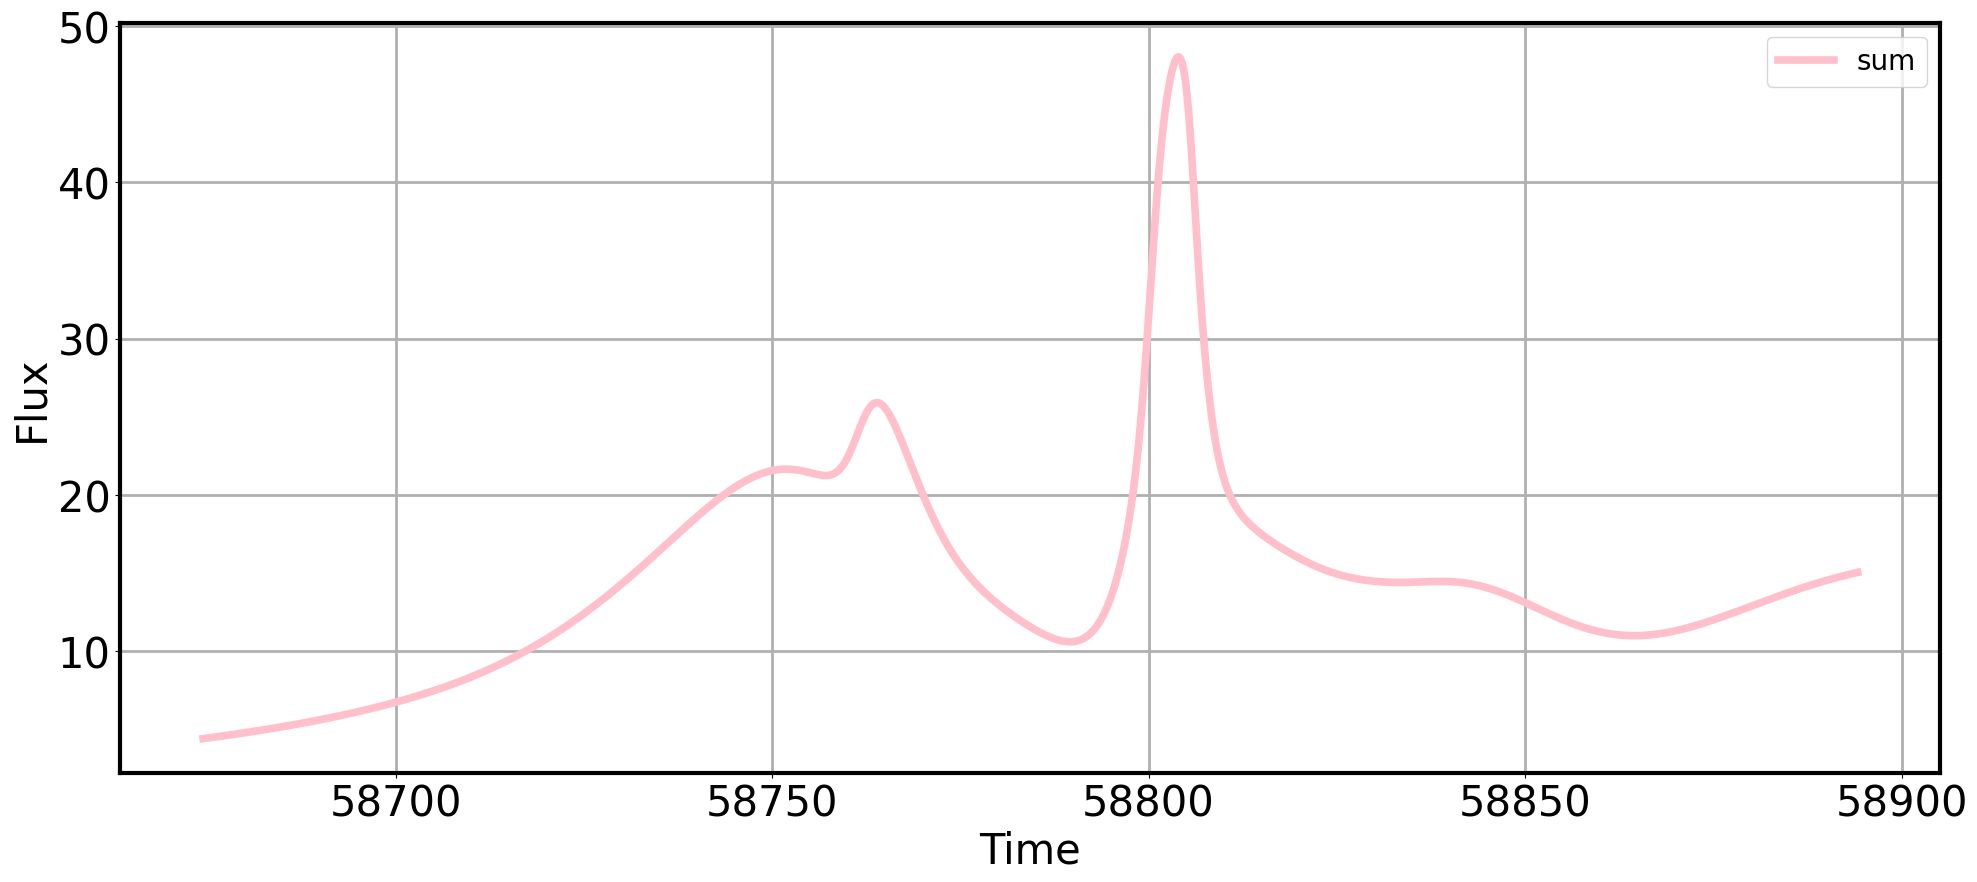

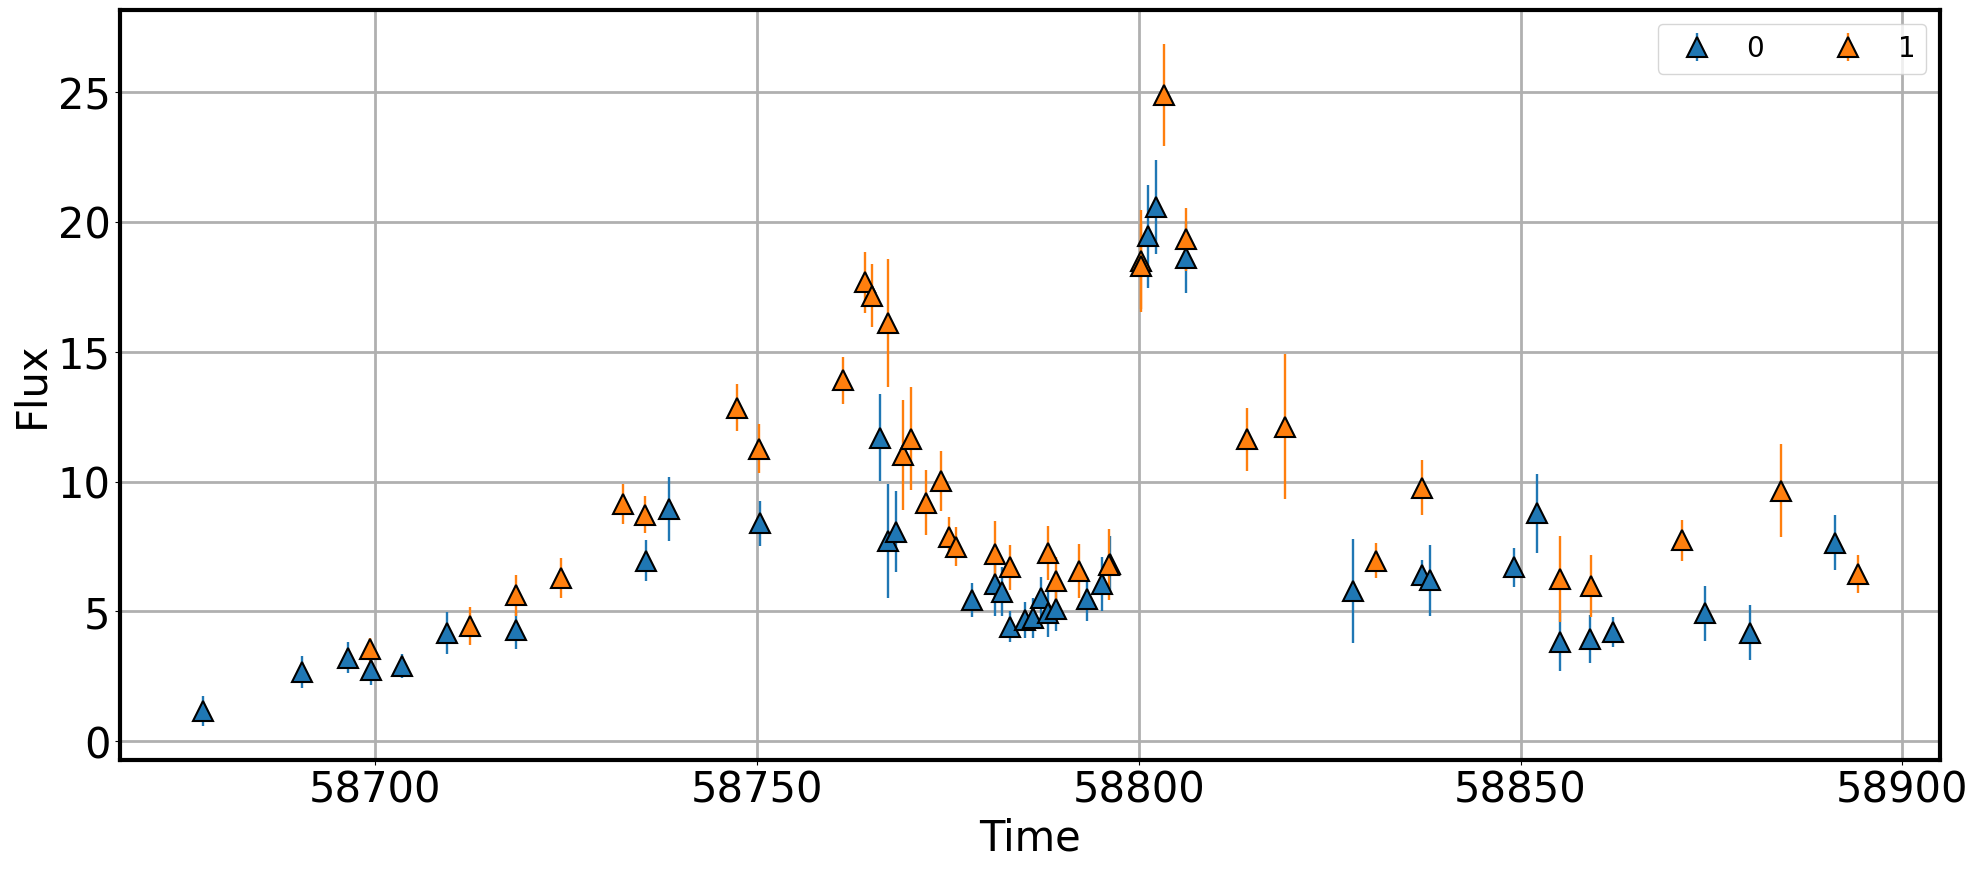

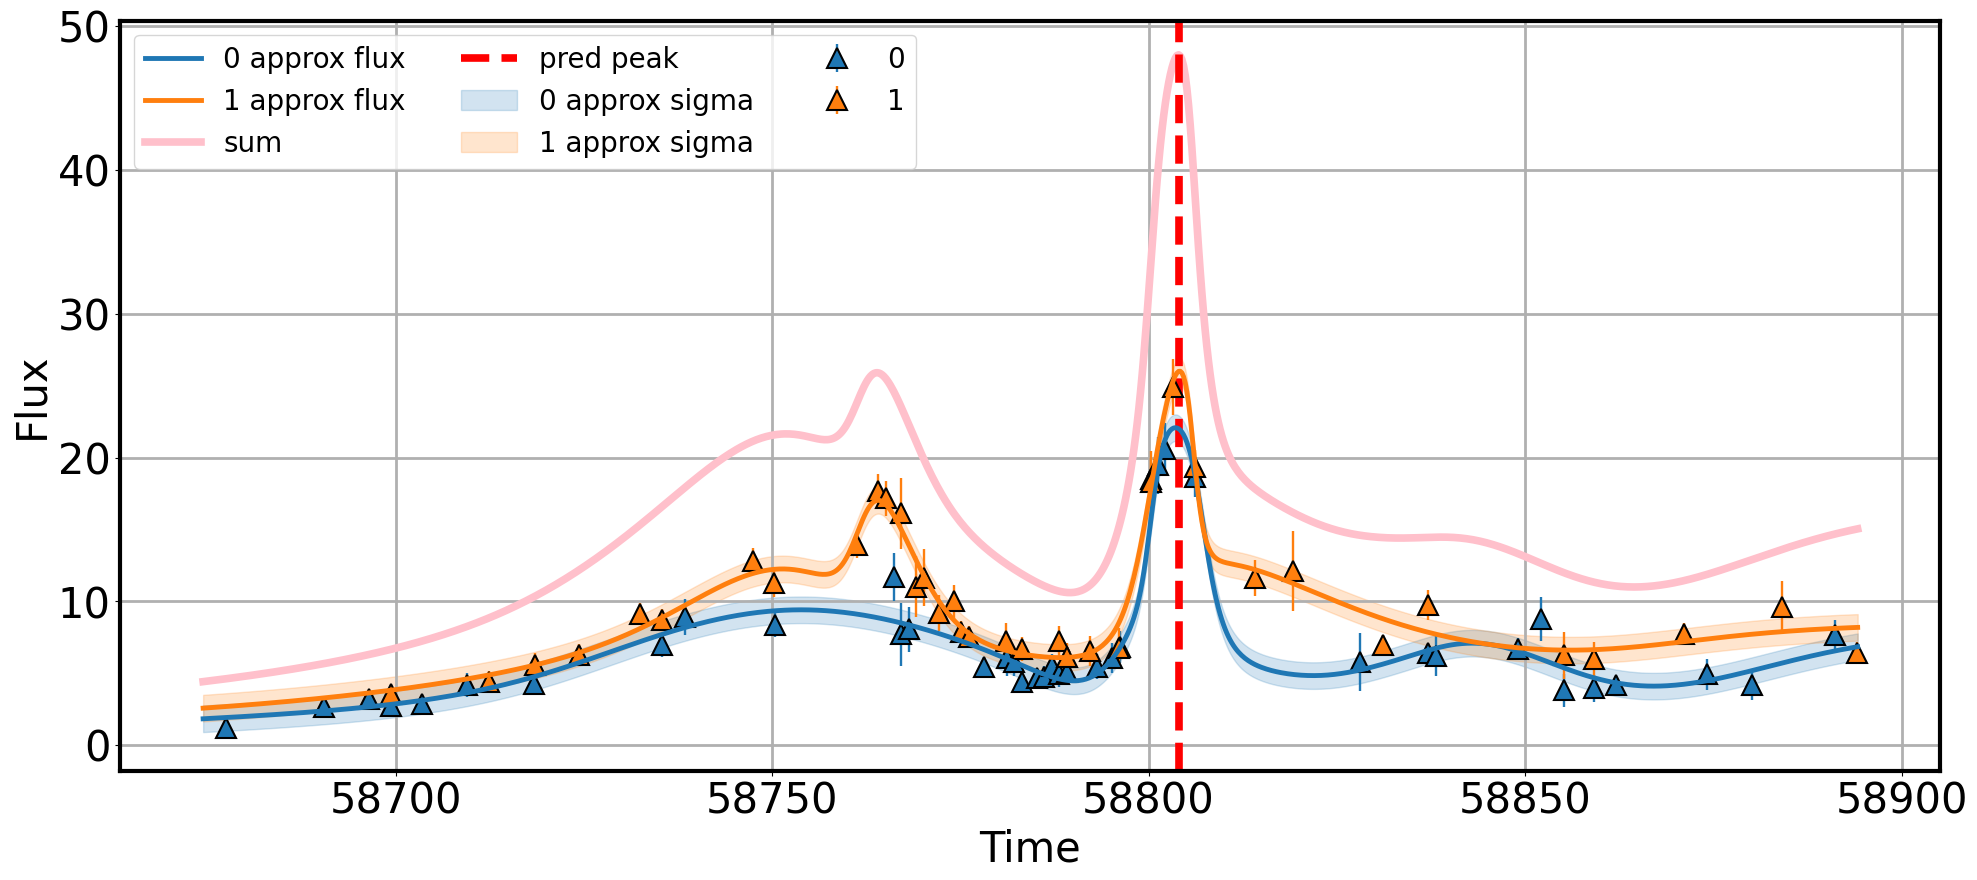

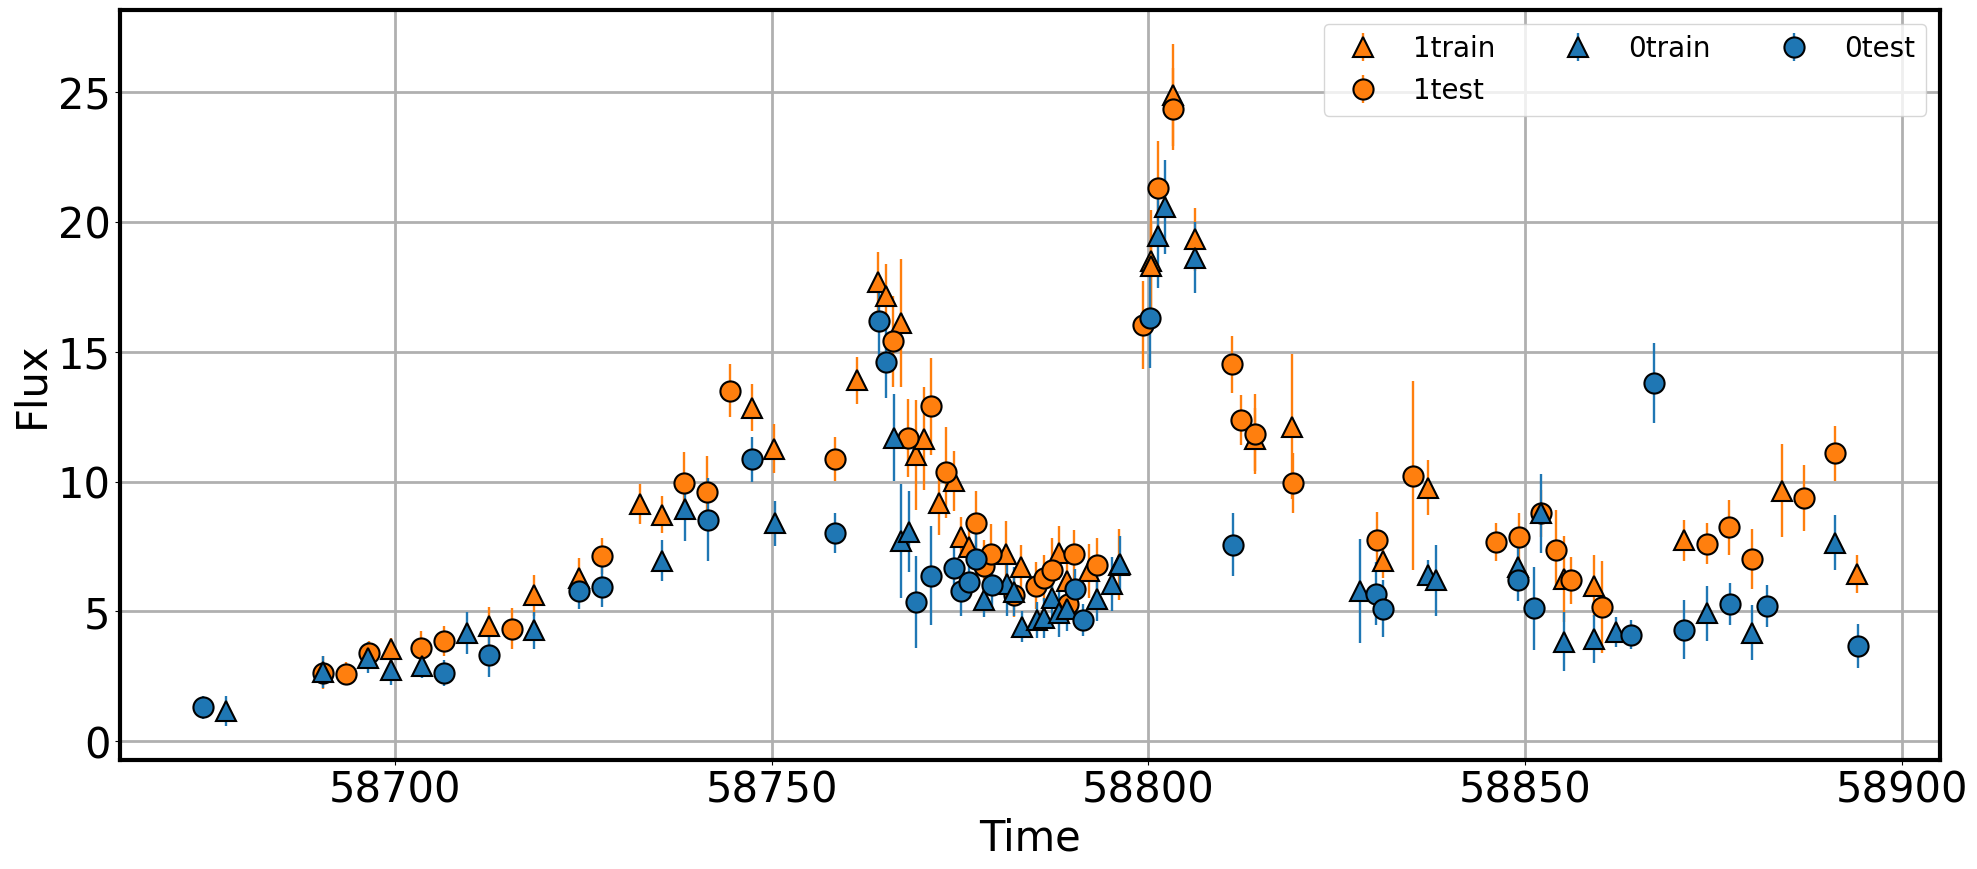

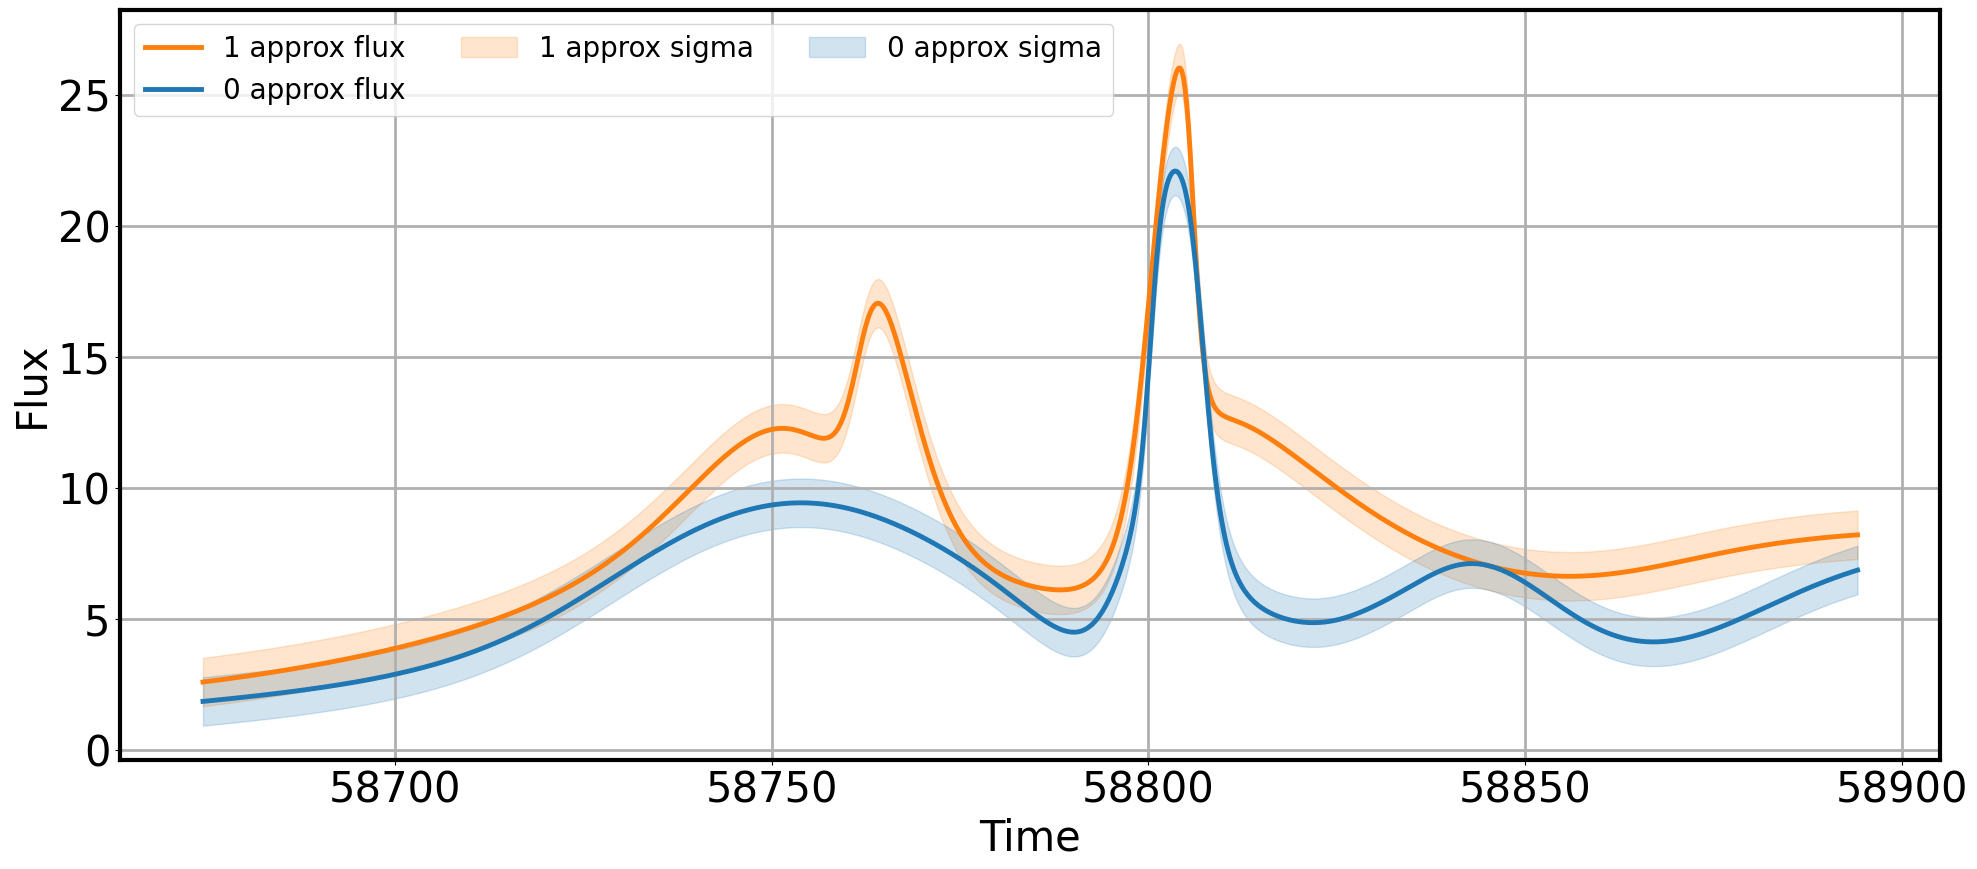

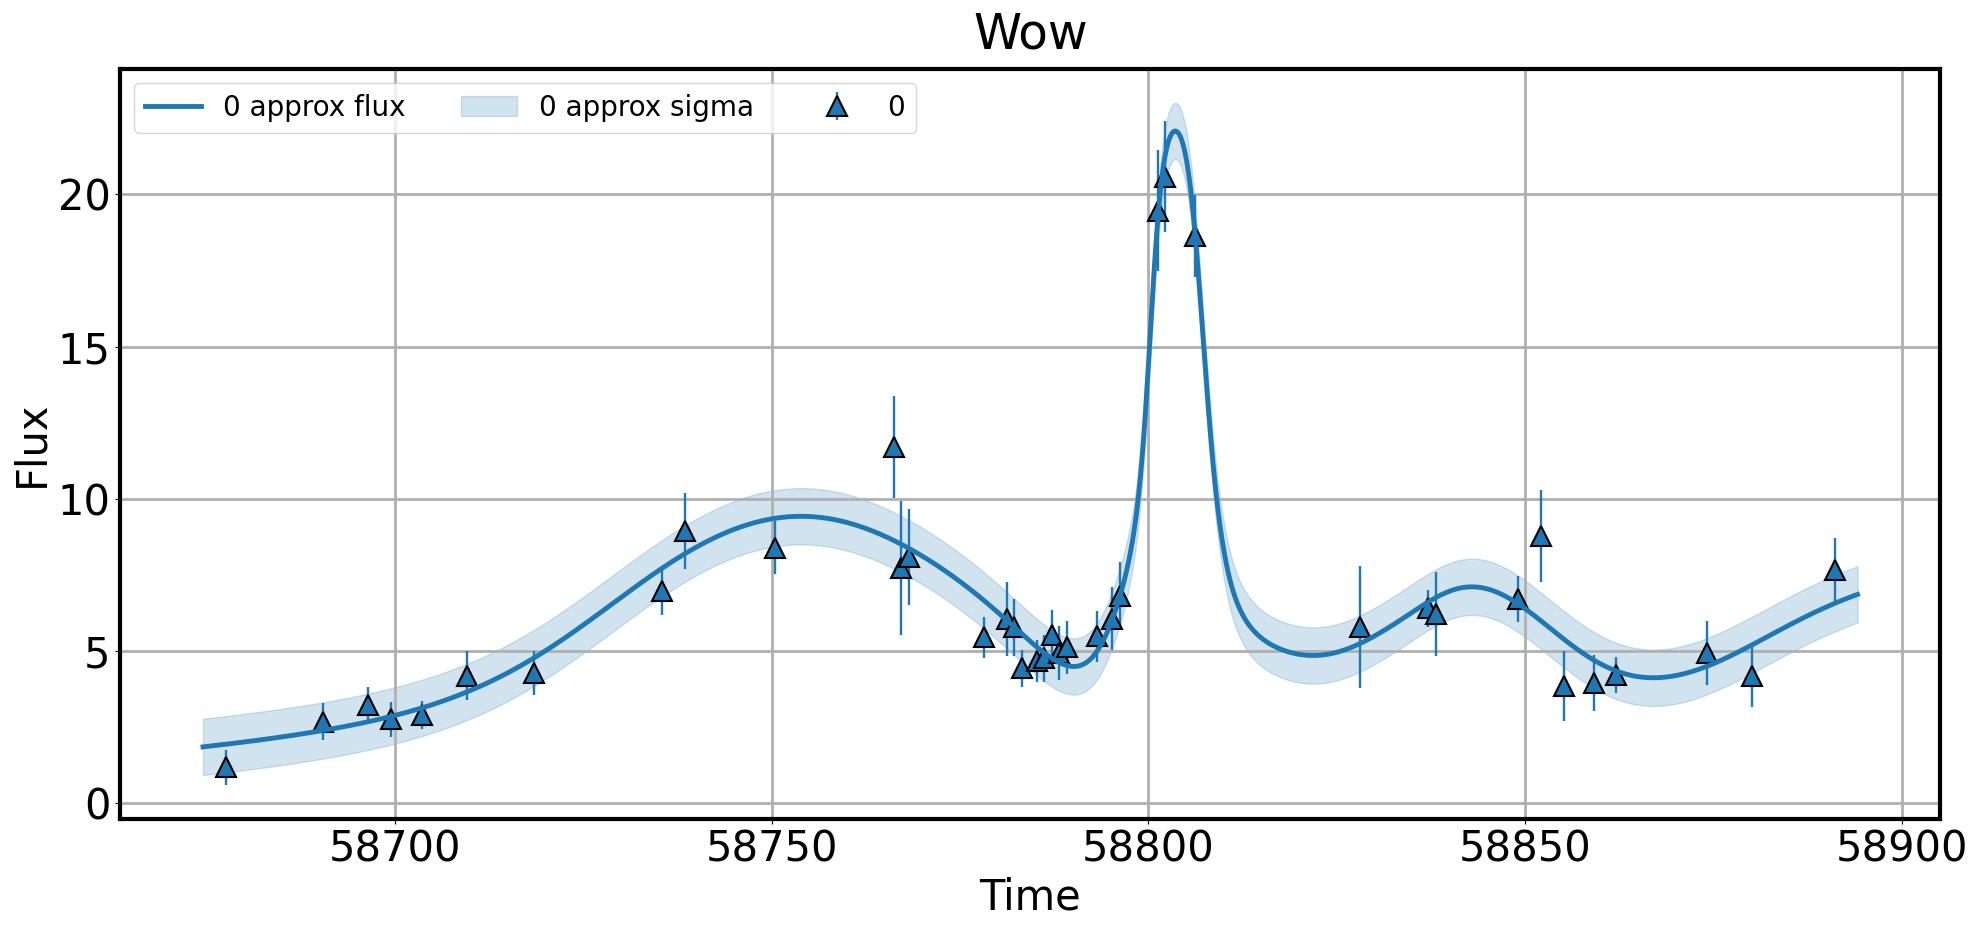

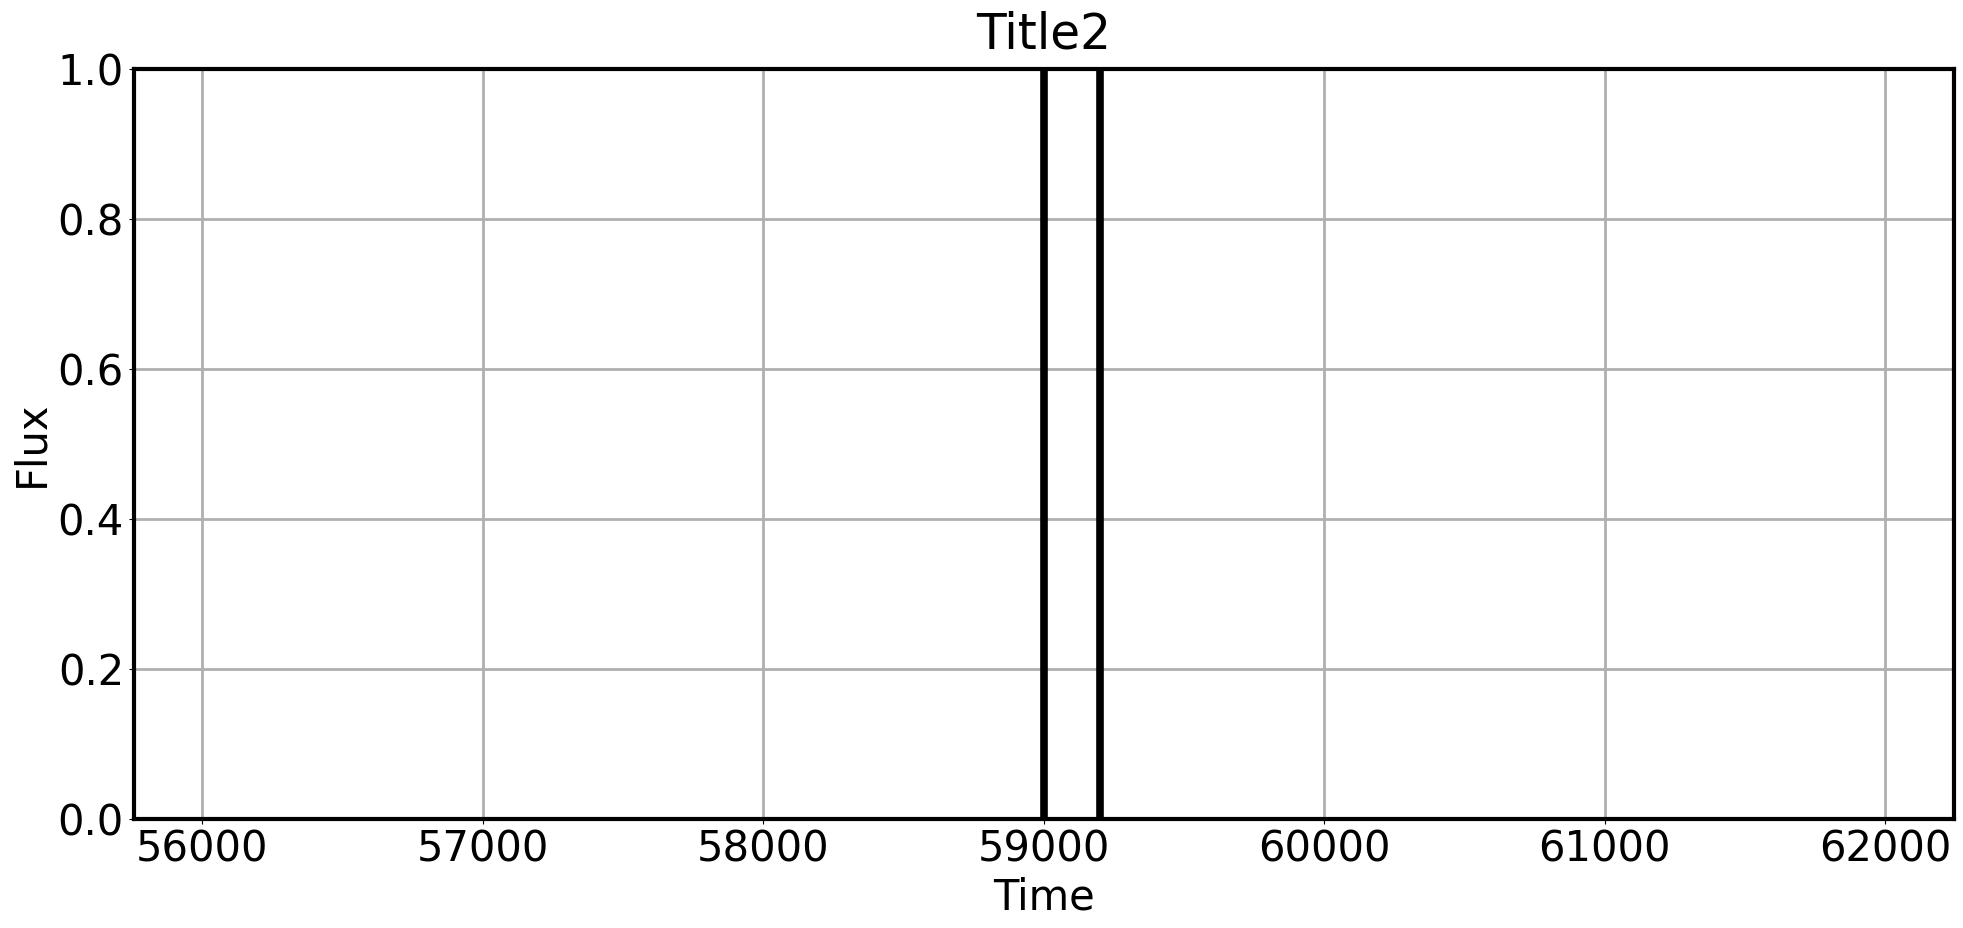

In [2]:
test('NN (sklearn)')

<AxesSubplot:title={'center':'2 objects on one graph'}, xlabel='Time', ylabel='Flux'>

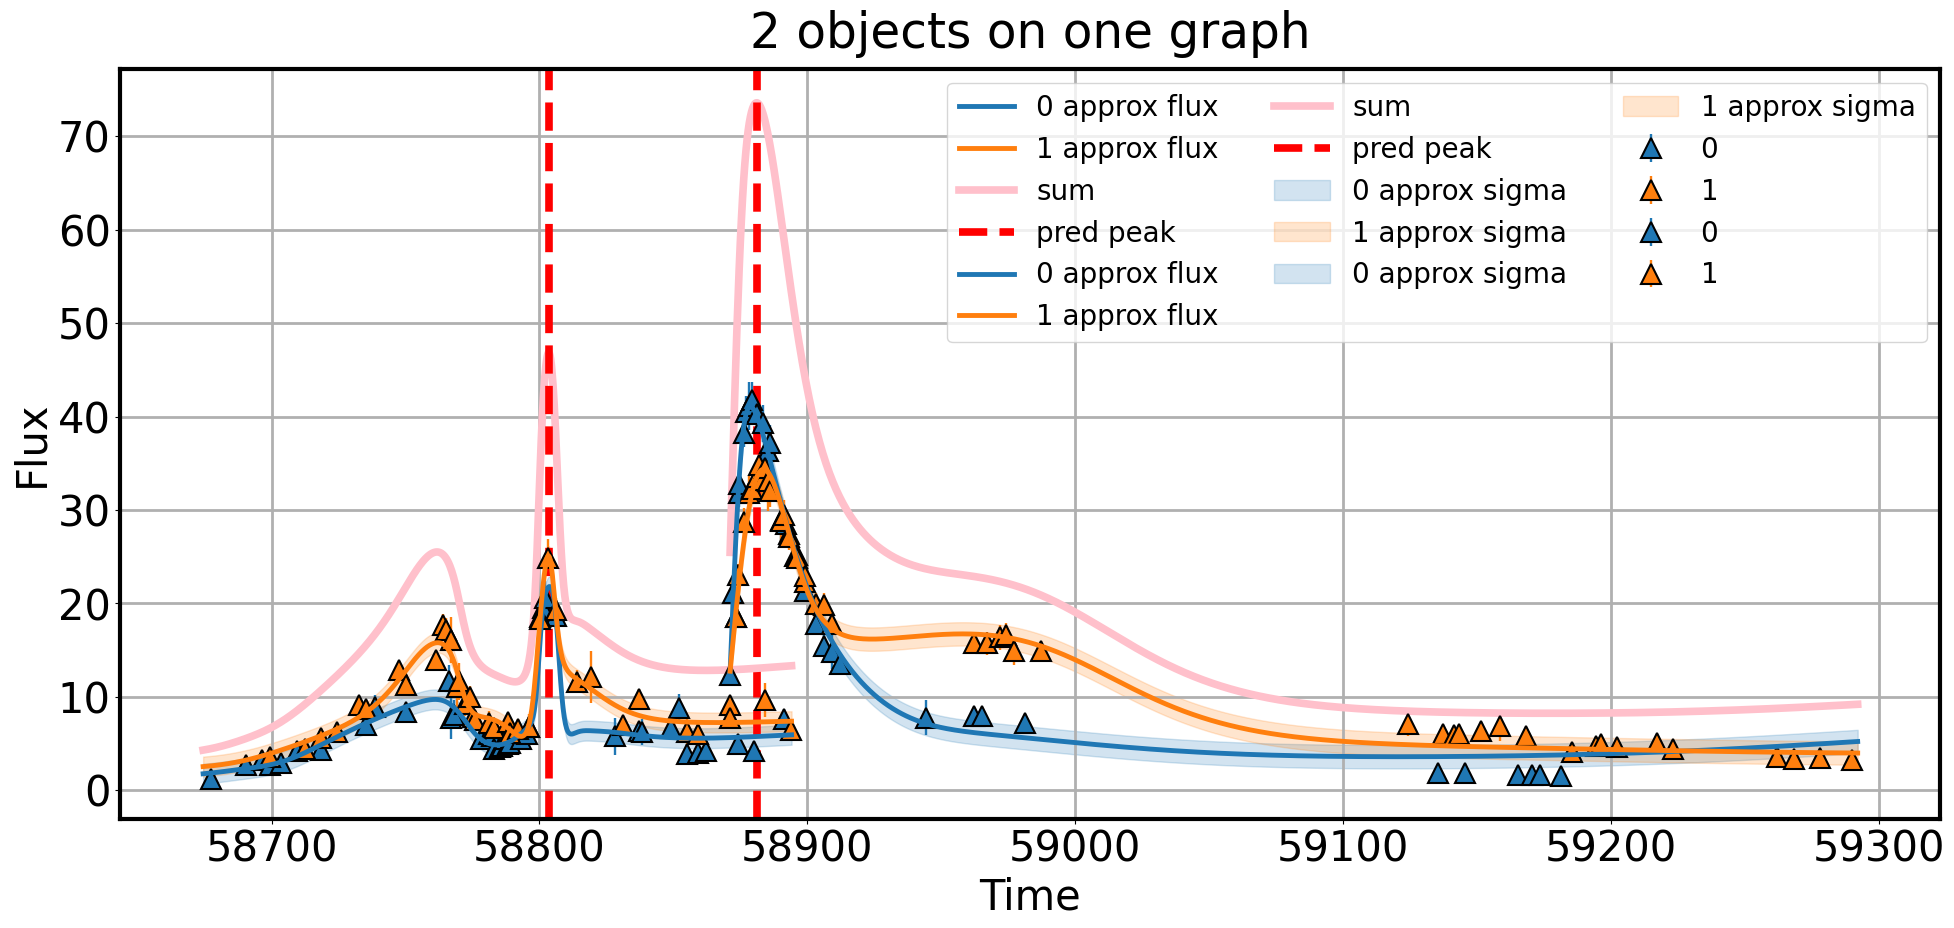

In [3]:
#2 objects on one graph:
model = models_dict['NN (sklearn)']
plotic = LcPlotter(passband2lam)

name1 = 'ZTF20aahbamv'
anobject1 = aug_standart_ztf.get_object(df_all, name1)
anobject1_train, anobject1_test = train_test_split(anobject1, test_size = 0.5, random_state=11)

model.fit(anobject1_train['mjd'].values, anobject1_train['flux'].values, 
              anobject1_train['flux_err'].values, anobject1_train['passband'].values)

t1_aug, flux1_aug, flux1_err_aug, passbands1_aug = model.augmentation(anobject1['mjd'].min(), 
                                                                      anobject1['mjd'].max(), 
                                                                      n_obs=N_OBS)
name2 = 'ZTF19abirmkt'
anobject2 = aug_standart_ztf.get_object(df_all, name2)
anobject2_train, anobject2_test = train_test_split(anobject2, test_size = 0.5, random_state=11)

model.fit(anobject2_train['mjd'].values, anobject2_train['flux'].values, 
              anobject2_train['flux_err'].values, anobject2_train['passband'].values)

t2_aug, flux2_aug, flux2_err_aug, passbands2_aug = model.augmentation(anobject2['mjd'].min(), 
                                                                      anobject2['mjd'].max(), 
                                                                      n_obs=N_OBS)
ax = plotic.plot_one_graph_all(t=anobject1_train['mjd'].values,
                             flux=anobject1_train['flux'].values,
                             flux_err=anobject1_train['flux_err'].values,
                             passbands=anobject1_train['passband'].values, 
                                  plot_peak=True,
                                  t_approx=t1_aug, 
                                  flux_approx=flux1_aug,
                                  flux_err_approx=flux1_err_aug, 
                                  passband_approx=passbands1_aug)
plotic.plot_one_graph_all(t=anobject2_train['mjd'].values,
                             flux=anobject2_train['flux'].values,
                             flux_err=anobject2_train['flux_err'].values,
                             passbands=anobject2_train['passband'].values, 
                                  plot_peak=True,
                                  t_approx=t2_aug, 
                                  flux_approx=flux2_aug,
                                  flux_err_approx=flux2_err_aug, 
                                  passband_approx=passbands2_aug, ax=ax, title="2 objects on one graph")